# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

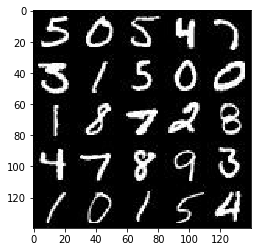

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

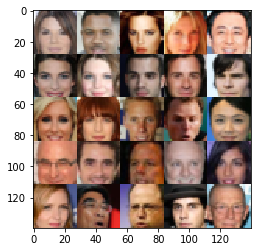

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_input')
    z_input = tf.placeholder(tf.float32,(None,z_dim),name='z_input')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    return real_input,z_input,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images,32,5,strides=2,padding='same')
        x1 = tf.maximum(.2*x1,x1)
        # 14x14x32
        x2 = tf.layers.conv2d(x1,64,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training = True)
        x2 = tf.maximum(.2*x2,x2)
        # 7x7x64
        x3 = tf.layers.conv2d(x2,128,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3,training = True)
        x3 = tf.maximum(.2*x3,x3)
        # 4x4x128
        x4 = tf.reshape(x3,(-1,4*4*128))
        logits = tf.layers.dense(x4,1)
        output = tf.sigmoid(logits)

    return output,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=(not is_train)):
        x1 = tf.layers.dense(z,2*2*512)
        x1 = tf.reshape(x1,(-1,2,2,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(.2*x1,x1)
        # 2x2x512
        x2 = tf.layers.conv2d_transpose(x1,256,kernel_size=5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(.2*x2,x2)
        # 4x4x256
        x3 = tf.layers.conv2d_transpose(x2,128,kernel_size=4,strides=1,padding='valid')
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(.2*x3,x3)
        # 7x7x128
        x4 = tf.layers.conv2d_transpose(x3,64,kernel_size=5,strides=2,padding='same')
        x4 = tf.layers.batch_normalization(x4,training=is_train)
        x4 = tf.maximum(.2*x4,x4)
        # 14x14x64
        logits = tf.layers.conv2d_transpose(x4,out_channel_dim,kernel_size=5,strides=2,padding='same')
        
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real,d_logits_real = discriminator(input_real)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse=True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)*0.9))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
        
    return d_opt,g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # saver = tf.train.Saver()
    
    losses = []
    iterations = 0

    real_input,z_input,learning_r = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss,g_loss = model_loss(real_input,z_input,data_shape[3])
    d_opt,g_opt = model_opt(d_loss,g_loss,learning_r,beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                iterations += 1 
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
            
                batch_images = batch_images*2
                  
                _g = sess.run(g_opt,feed_dict={real_input: batch_images,z_input: batch_z,learning_r: learning_rate})
                _d = sess.run(d_opt,feed_dict={real_input: batch_images,z_input: batch_z,learning_r: learning_rate})
                
                if iterations % 10 == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})
                    
                    print("Epoch {}/{} ... ".format(epoch_i,epoch_count),"Discriminator Loss {} ... ".format(train_loss_d),"Generator Loss {} ".format(train_loss_g))
                    losses.append((train_loss_d,train_loss_g))
                    
                if iterations % 100 == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)
                    
        #saver.save(sess, './checkpoints/generator.ckpt')
        
    
    return losses 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2 ...  Discriminator Loss 0.645555853843689 ...  Generator Loss 2.5654187202453613 
Epoch 0/2 ...  Discriminator Loss 1.4038362503051758 ...  Generator Loss 0.58376145362854 
Epoch 0/2 ...  Discriminator Loss 0.7676734924316406 ...  Generator Loss 2.452603578567505 
Epoch 0/2 ...  Discriminator Loss 1.1954652070999146 ...  Generator Loss 0.794028103351593 
Epoch 0/2 ...  Discriminator Loss 0.7276982665061951 ...  Generator Loss 1.2535247802734375 
Epoch 0/2 ...  Discriminator Loss 0.6581636071205139 ...  Generator Loss 1.6267797946929932 
Epoch 0/2 ...  Discriminator Loss 0.5147423148155212 ...  Generator Loss 2.7205123901367188 
Epoch 0/2 ...  Discriminator Loss 1.017987847328186 ...  Generator Loss 1.0443077087402344 
Epoch 0/2 ...  Discriminator Loss 1.0395312309265137 ...  Generator Loss 1.1711041927337646 
Epoch 0/2 ...  Discriminator Loss 1.0590084791183472 ...  Generator Loss 0.9115617871284485 


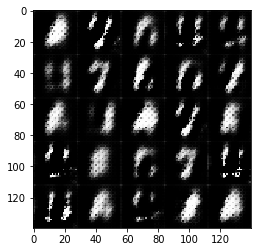

Epoch 0/2 ...  Discriminator Loss 0.5119266510009766 ...  Generator Loss 2.2866573333740234 
Epoch 0/2 ...  Discriminator Loss 1.2669917345046997 ...  Generator Loss 0.7932230830192566 
Epoch 0/2 ...  Discriminator Loss 0.7259165048599243 ...  Generator Loss 1.4441320896148682 
Epoch 0/2 ...  Discriminator Loss 1.090684175491333 ...  Generator Loss 2.976851224899292 
Epoch 0/2 ...  Discriminator Loss 1.229601502418518 ...  Generator Loss 2.6674766540527344 
Epoch 0/2 ...  Discriminator Loss 1.0390816926956177 ...  Generator Loss 2.869306802749634 
Epoch 0/2 ...  Discriminator Loss 1.0455533266067505 ...  Generator Loss 2.5484097003936768 
Epoch 0/2 ...  Discriminator Loss 1.0365794897079468 ...  Generator Loss 1.0006850957870483 
Epoch 0/2 ...  Discriminator Loss 1.128772258758545 ...  Generator Loss 0.9072394371032715 
Epoch 0/2 ...  Discriminator Loss 0.9936862587928772 ...  Generator Loss 1.113985300064087 


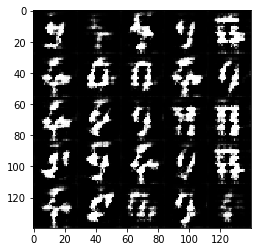

Epoch 0/2 ...  Discriminator Loss 1.0198390483856201 ...  Generator Loss 0.823165237903595 
Epoch 0/2 ...  Discriminator Loss 0.9718596935272217 ...  Generator Loss 1.06015944480896 
Epoch 0/2 ...  Discriminator Loss 0.8864125609397888 ...  Generator Loss 1.4826148748397827 
Epoch 0/2 ...  Discriminator Loss 1.0666766166687012 ...  Generator Loss 1.5739904642105103 
Epoch 0/2 ...  Discriminator Loss 1.1012060642242432 ...  Generator Loss 1.8821961879730225 
Epoch 0/2 ...  Discriminator Loss 1.3891029357910156 ...  Generator Loss 2.5916996002197266 
Epoch 0/2 ...  Discriminator Loss 1.3068065643310547 ...  Generator Loss 2.419114589691162 
Epoch 0/2 ...  Discriminator Loss 1.1009777784347534 ...  Generator Loss 2.028531551361084 
Epoch 0/2 ...  Discriminator Loss 1.2469598054885864 ...  Generator Loss 2.6136350631713867 
Epoch 0/2 ...  Discriminator Loss 0.9173601865768433 ...  Generator Loss 1.5670874118804932 


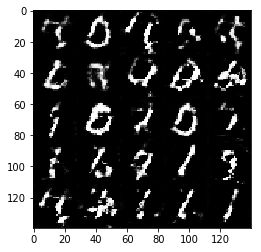

Epoch 0/2 ...  Discriminator Loss 1.3738305568695068 ...  Generator Loss 2.5983848571777344 
Epoch 0/2 ...  Discriminator Loss 1.0597702264785767 ...  Generator Loss 1.2199180126190186 
Epoch 0/2 ...  Discriminator Loss 1.0890254974365234 ...  Generator Loss 0.8587274551391602 
Epoch 0/2 ...  Discriminator Loss 1.1658973693847656 ...  Generator Loss 0.7228036522865295 
Epoch 0/2 ...  Discriminator Loss 1.1125831604003906 ...  Generator Loss 1.5838805437088013 
Epoch 0/2 ...  Discriminator Loss 1.2690482139587402 ...  Generator Loss 1.9244592189788818 
Epoch 0/2 ...  Discriminator Loss 1.070453405380249 ...  Generator Loss 1.4865875244140625 
Epoch 0/2 ...  Discriminator Loss 1.0329713821411133 ...  Generator Loss 1.2505395412445068 
Epoch 0/2 ...  Discriminator Loss 1.1115708351135254 ...  Generator Loss 0.9293479919433594 
Epoch 0/2 ...  Discriminator Loss 1.1239731311798096 ...  Generator Loss 0.8848378658294678 


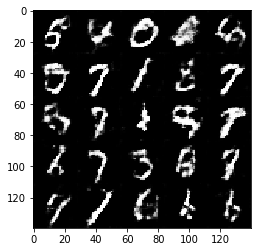

Epoch 0/2 ...  Discriminator Loss 1.0847984552383423 ...  Generator Loss 1.0750114917755127 
Epoch 0/2 ...  Discriminator Loss 1.3659900426864624 ...  Generator Loss 0.5498472452163696 
Epoch 0/2 ...  Discriminator Loss 1.0244767665863037 ...  Generator Loss 1.0348764657974243 
Epoch 0/2 ...  Discriminator Loss 1.1249151229858398 ...  Generator Loss 1.0464138984680176 
Epoch 0/2 ...  Discriminator Loss 1.2431546449661255 ...  Generator Loss 1.8595616817474365 
Epoch 0/2 ...  Discriminator Loss 1.155916452407837 ...  Generator Loss 1.2963248491287231 
Epoch 0/2 ...  Discriminator Loss 1.1312090158462524 ...  Generator Loss 1.525086522102356 
Epoch 0/2 ...  Discriminator Loss 1.1935508251190186 ...  Generator Loss 1.1007299423217773 
Epoch 0/2 ...  Discriminator Loss 1.3390084505081177 ...  Generator Loss 1.8904508352279663 
Epoch 0/2 ...  Discriminator Loss 1.1525139808654785 ...  Generator Loss 1.3559482097625732 


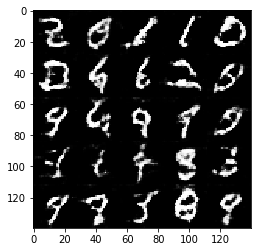

Epoch 0/2 ...  Discriminator Loss 1.1136739253997803 ...  Generator Loss 1.2047407627105713 
Epoch 0/2 ...  Discriminator Loss 1.2009849548339844 ...  Generator Loss 0.7302641868591309 
Epoch 0/2 ...  Discriminator Loss 1.14927339553833 ...  Generator Loss 0.7784189581871033 
Epoch 0/2 ...  Discriminator Loss 1.152808666229248 ...  Generator Loss 0.8939687013626099 
Epoch 0/2 ...  Discriminator Loss 1.1247726678848267 ...  Generator Loss 0.9686306715011597 
Epoch 0/2 ...  Discriminator Loss 1.136265754699707 ...  Generator Loss 0.822966456413269 
Epoch 0/2 ...  Discriminator Loss 1.1342463493347168 ...  Generator Loss 0.8705569505691528 
Epoch 0/2 ...  Discriminator Loss 1.1216942071914673 ...  Generator Loss 1.0088567733764648 
Epoch 0/2 ...  Discriminator Loss 1.1873364448547363 ...  Generator Loss 0.9246916770935059 
Epoch 0/2 ...  Discriminator Loss 1.29256010055542 ...  Generator Loss 1.6367970705032349 


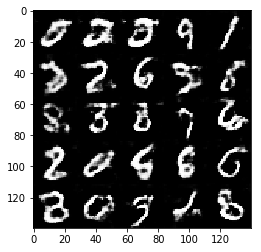

Epoch 0/2 ...  Discriminator Loss 1.0510499477386475 ...  Generator Loss 1.0876071453094482 
Epoch 0/2 ...  Discriminator Loss 1.2456263303756714 ...  Generator Loss 1.2608327865600586 
Epoch 0/2 ...  Discriminator Loss 1.2560961246490479 ...  Generator Loss 1.3073246479034424 
Epoch 0/2 ...  Discriminator Loss 1.174706220626831 ...  Generator Loss 1.4519617557525635 
Epoch 0/2 ...  Discriminator Loss 1.1929630041122437 ...  Generator Loss 1.4068708419799805 
Epoch 0/2 ...  Discriminator Loss 1.3499951362609863 ...  Generator Loss 1.689732551574707 
Epoch 0/2 ...  Discriminator Loss 1.201867938041687 ...  Generator Loss 0.7317986488342285 
Epoch 0/2 ...  Discriminator Loss 1.1939278841018677 ...  Generator Loss 0.8198317885398865 
Epoch 0/2 ...  Discriminator Loss 1.144642949104309 ...  Generator Loss 1.0010420083999634 
Epoch 0/2 ...  Discriminator Loss 1.184043288230896 ...  Generator Loss 1.4169306755065918 


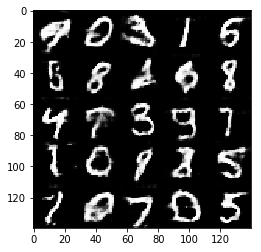

Epoch 0/2 ...  Discriminator Loss 1.1771124601364136 ...  Generator Loss 1.4944219589233398 
Epoch 0/2 ...  Discriminator Loss 1.243240237236023 ...  Generator Loss 1.209177017211914 
Epoch 0/2 ...  Discriminator Loss 1.1825804710388184 ...  Generator Loss 1.2399414777755737 
Epoch 0/2 ...  Discriminator Loss 1.1806645393371582 ...  Generator Loss 0.7621288299560547 
Epoch 0/2 ...  Discriminator Loss 1.1959114074707031 ...  Generator Loss 0.8667952418327332 
Epoch 0/2 ...  Discriminator Loss 1.1831307411193848 ...  Generator Loss 0.9609017968177795 
Epoch 0/2 ...  Discriminator Loss 1.208143711090088 ...  Generator Loss 1.5216113328933716 
Epoch 0/2 ...  Discriminator Loss 1.164597988128662 ...  Generator Loss 1.184499740600586 
Epoch 0/2 ...  Discriminator Loss 1.278674840927124 ...  Generator Loss 1.5355372428894043 
Epoch 0/2 ...  Discriminator Loss 1.2142634391784668 ...  Generator Loss 0.8244403600692749 


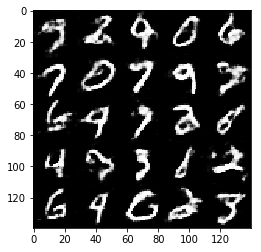

Epoch 0/2 ...  Discriminator Loss 1.2383333444595337 ...  Generator Loss 1.0961010456085205 
Epoch 0/2 ...  Discriminator Loss 1.2124505043029785 ...  Generator Loss 0.9073539972305298 
Epoch 0/2 ...  Discriminator Loss 1.1365702152252197 ...  Generator Loss 1.2588751316070557 
Epoch 0/2 ...  Discriminator Loss 1.0877219438552856 ...  Generator Loss 1.1911063194274902 
Epoch 0/2 ...  Discriminator Loss 1.2117302417755127 ...  Generator Loss 1.1583091020584106 
Epoch 0/2 ...  Discriminator Loss 1.1793982982635498 ...  Generator Loss 0.8813163638114929 
Epoch 0/2 ...  Discriminator Loss 1.1902185678482056 ...  Generator Loss 0.9026395082473755 
Epoch 0/2 ...  Discriminator Loss 1.2129912376403809 ...  Generator Loss 0.7630306482315063 
Epoch 0/2 ...  Discriminator Loss 1.1724340915679932 ...  Generator Loss 0.800822913646698 
Epoch 0/2 ...  Discriminator Loss 1.254996657371521 ...  Generator Loss 0.6597921848297119 


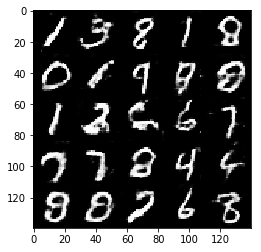

Epoch 0/2 ...  Discriminator Loss 1.1849174499511719 ...  Generator Loss 0.8132923245429993 
Epoch 0/2 ...  Discriminator Loss 1.2133870124816895 ...  Generator Loss 0.7718991041183472 
Epoch 0/2 ...  Discriminator Loss 1.151259183883667 ...  Generator Loss 1.094412088394165 
Epoch 1/2 ...  Discriminator Loss 1.365788459777832 ...  Generator Loss 1.6904863119125366 
Epoch 1/2 ...  Discriminator Loss 1.2478114366531372 ...  Generator Loss 0.7891930341720581 
Epoch 1/2 ...  Discriminator Loss 1.134443998336792 ...  Generator Loss 0.9250108599662781 
Epoch 1/2 ...  Discriminator Loss 1.23222815990448 ...  Generator Loss 0.8494490385055542 
Epoch 1/2 ...  Discriminator Loss 1.256255865097046 ...  Generator Loss 0.7264774441719055 
Epoch 1/2 ...  Discriminator Loss 1.1930932998657227 ...  Generator Loss 0.9580485820770264 
Epoch 1/2 ...  Discriminator Loss 1.1993231773376465 ...  Generator Loss 1.057600736618042 


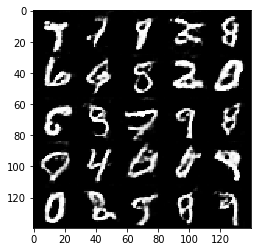

Epoch 1/2 ...  Discriminator Loss 1.0924594402313232 ...  Generator Loss 0.9414016008377075 
Epoch 1/2 ...  Discriminator Loss 1.240513801574707 ...  Generator Loss 0.7691329717636108 
Epoch 1/2 ...  Discriminator Loss 1.213629961013794 ...  Generator Loss 0.7630434036254883 
Epoch 1/2 ...  Discriminator Loss 1.2470238208770752 ...  Generator Loss 0.7492659091949463 
Epoch 1/2 ...  Discriminator Loss 1.2314963340759277 ...  Generator Loss 1.4584310054779053 
Epoch 1/2 ...  Discriminator Loss 1.1500732898712158 ...  Generator Loss 0.9549778699874878 
Epoch 1/2 ...  Discriminator Loss 1.1534218788146973 ...  Generator Loss 1.2333173751831055 
Epoch 1/2 ...  Discriminator Loss 1.251429557800293 ...  Generator Loss 0.902152419090271 
Epoch 1/2 ...  Discriminator Loss 1.0979280471801758 ...  Generator Loss 1.1344153881072998 
Epoch 1/2 ...  Discriminator Loss 1.3571743965148926 ...  Generator Loss 1.6326243877410889 


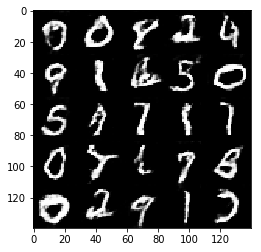

Epoch 1/2 ...  Discriminator Loss 1.2738394737243652 ...  Generator Loss 0.8715020418167114 
Epoch 1/2 ...  Discriminator Loss 1.1732068061828613 ...  Generator Loss 1.0632781982421875 
Epoch 1/2 ...  Discriminator Loss 1.2044672966003418 ...  Generator Loss 1.280231237411499 
Epoch 1/2 ...  Discriminator Loss 1.2345879077911377 ...  Generator Loss 1.100745439529419 
Epoch 1/2 ...  Discriminator Loss 1.2407360076904297 ...  Generator Loss 1.1555713415145874 
Epoch 1/2 ...  Discriminator Loss 1.1602694988250732 ...  Generator Loss 0.7593920826911926 
Epoch 1/2 ...  Discriminator Loss 1.2847331762313843 ...  Generator Loss 1.4127511978149414 
Epoch 1/2 ...  Discriminator Loss 1.2515532970428467 ...  Generator Loss 1.465477705001831 
Epoch 1/2 ...  Discriminator Loss 1.1967442035675049 ...  Generator Loss 0.9513038396835327 
Epoch 1/2 ...  Discriminator Loss 1.1784838438034058 ...  Generator Loss 0.8658959269523621 


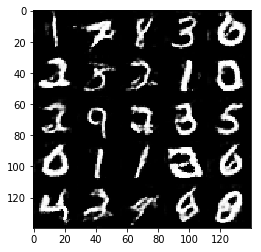

Epoch 1/2 ...  Discriminator Loss 1.2220360040664673 ...  Generator Loss 0.7759876251220703 
Epoch 1/2 ...  Discriminator Loss 1.3035796880722046 ...  Generator Loss 0.8888654112815857 
Epoch 1/2 ...  Discriminator Loss 1.2313365936279297 ...  Generator Loss 1.013071060180664 
Epoch 1/2 ...  Discriminator Loss 1.1537973880767822 ...  Generator Loss 0.9908841252326965 
Epoch 1/2 ...  Discriminator Loss 1.2643917798995972 ...  Generator Loss 0.7603249549865723 
Epoch 1/2 ...  Discriminator Loss 1.203045129776001 ...  Generator Loss 0.9554910659790039 
Epoch 1/2 ...  Discriminator Loss 1.212153434753418 ...  Generator Loss 0.7969956994056702 
Epoch 1/2 ...  Discriminator Loss 1.1838810443878174 ...  Generator Loss 0.8781688213348389 
Epoch 1/2 ...  Discriminator Loss 1.1628272533416748 ...  Generator Loss 0.9082343578338623 
Epoch 1/2 ...  Discriminator Loss 1.1768664121627808 ...  Generator Loss 1.066827416419983 


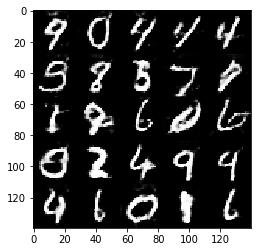

Epoch 1/2 ...  Discriminator Loss 1.2162752151489258 ...  Generator Loss 0.6811935305595398 
Epoch 1/2 ...  Discriminator Loss 1.1933534145355225 ...  Generator Loss 0.9152805805206299 
Epoch 1/2 ...  Discriminator Loss 1.081254243850708 ...  Generator Loss 1.0897331237792969 
Epoch 1/2 ...  Discriminator Loss 1.178865671157837 ...  Generator Loss 1.3394759893417358 
Epoch 1/2 ...  Discriminator Loss 1.2585511207580566 ...  Generator Loss 0.6655014157295227 
Epoch 1/2 ...  Discriminator Loss 1.1858704090118408 ...  Generator Loss 0.9519767761230469 
Epoch 1/2 ...  Discriminator Loss 1.1580603122711182 ...  Generator Loss 1.9872727394104004 
Epoch 1/2 ...  Discriminator Loss 1.2509169578552246 ...  Generator Loss 0.9111596345901489 
Epoch 1/2 ...  Discriminator Loss 1.1549906730651855 ...  Generator Loss 0.8469239473342896 
Epoch 1/2 ...  Discriminator Loss 1.166783332824707 ...  Generator Loss 1.0208265781402588 


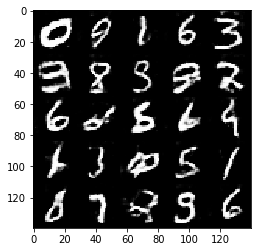

Epoch 1/2 ...  Discriminator Loss 1.4120097160339355 ...  Generator Loss 0.7186316251754761 
Epoch 1/2 ...  Discriminator Loss 1.329836368560791 ...  Generator Loss 0.792788028717041 
Epoch 1/2 ...  Discriminator Loss 1.315464973449707 ...  Generator Loss 0.9446737170219421 
Epoch 1/2 ...  Discriminator Loss 1.280256986618042 ...  Generator Loss 0.8659414052963257 
Epoch 1/2 ...  Discriminator Loss 1.2597153186798096 ...  Generator Loss 0.8977243900299072 
Epoch 1/2 ...  Discriminator Loss 1.2344602346420288 ...  Generator Loss 0.9371169805526733 
Epoch 1/2 ...  Discriminator Loss 1.2242281436920166 ...  Generator Loss 1.0887634754180908 
Epoch 1/2 ...  Discriminator Loss 1.1797435283660889 ...  Generator Loss 0.9996258020401001 
Epoch 1/2 ...  Discriminator Loss 1.1832846403121948 ...  Generator Loss 1.053102731704712 
Epoch 1/2 ...  Discriminator Loss 1.131441593170166 ...  Generator Loss 1.071582555770874 


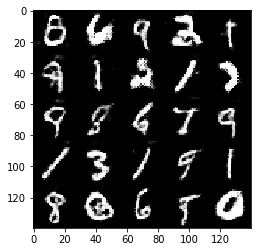

Epoch 1/2 ...  Discriminator Loss 1.1652042865753174 ...  Generator Loss 0.9058182239532471 
Epoch 1/2 ...  Discriminator Loss 1.2439182996749878 ...  Generator Loss 0.6348685026168823 
Epoch 1/2 ...  Discriminator Loss 1.2472822666168213 ...  Generator Loss 0.8842917084693909 
Epoch 1/2 ...  Discriminator Loss 1.2841445207595825 ...  Generator Loss 0.9957571029663086 
Epoch 1/2 ...  Discriminator Loss 1.231912612915039 ...  Generator Loss 1.0231963396072388 
Epoch 1/2 ...  Discriminator Loss 1.2040464878082275 ...  Generator Loss 0.9012126326560974 
Epoch 1/2 ...  Discriminator Loss 1.2173023223876953 ...  Generator Loss 1.041341781616211 
Epoch 1/2 ...  Discriminator Loss 1.1751677989959717 ...  Generator Loss 0.8723451495170593 
Epoch 1/2 ...  Discriminator Loss 1.1582012176513672 ...  Generator Loss 1.1214849948883057 
Epoch 1/2 ...  Discriminator Loss 1.1415659189224243 ...  Generator Loss 0.9443672299385071 


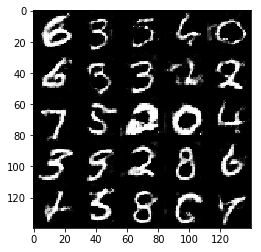

Epoch 1/2 ...  Discriminator Loss 1.1456924676895142 ...  Generator Loss 1.065459966659546 
Epoch 1/2 ...  Discriminator Loss 1.1616301536560059 ...  Generator Loss 0.8717935085296631 
Epoch 1/2 ...  Discriminator Loss 1.1998717784881592 ...  Generator Loss 0.9812761545181274 
Epoch 1/2 ...  Discriminator Loss 1.2681914567947388 ...  Generator Loss 1.4157719612121582 
Epoch 1/2 ...  Discriminator Loss 1.1855360269546509 ...  Generator Loss 0.8931806087493896 
Epoch 1/2 ...  Discriminator Loss 1.2083553075790405 ...  Generator Loss 1.8814456462860107 
Epoch 1/2 ...  Discriminator Loss 1.2315809726715088 ...  Generator Loss 0.8867849111557007 
Epoch 1/2 ...  Discriminator Loss 1.3192336559295654 ...  Generator Loss 0.5063194036483765 
Epoch 1/2 ...  Discriminator Loss 1.18403959274292 ...  Generator Loss 0.9192821383476257 
Epoch 1/2 ...  Discriminator Loss 1.1698520183563232 ...  Generator Loss 1.0137876272201538 


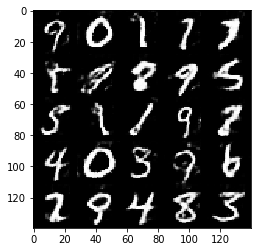

Epoch 1/2 ...  Discriminator Loss 1.1517877578735352 ...  Generator Loss 1.2888416051864624 
Epoch 1/2 ...  Discriminator Loss 1.19684636592865 ...  Generator Loss 1.0800209045410156 
Epoch 1/2 ...  Discriminator Loss 1.0114868879318237 ...  Generator Loss 1.156010627746582 
Epoch 1/2 ...  Discriminator Loss 1.1605738401412964 ...  Generator Loss 1.0192636251449585 
Epoch 1/2 ...  Discriminator Loss 1.152139663696289 ...  Generator Loss 1.6117491722106934 
Epoch 1/2 ...  Discriminator Loss 1.1669559478759766 ...  Generator Loss 0.9801371097564697 
Epoch 1/2 ...  Discriminator Loss 1.0553216934204102 ...  Generator Loss 1.0158705711364746 
Epoch 1/2 ...  Discriminator Loss 0.7106583118438721 ...  Generator Loss 1.3619202375411987 
Epoch 1/2 ...  Discriminator Loss 1.1836133003234863 ...  Generator Loss 1.146370768547058 
Epoch 1/2 ...  Discriminator Loss 1.1629447937011719 ...  Generator Loss 1.101557970046997 


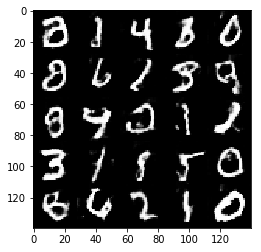

Epoch 1/2 ...  Discriminator Loss 1.0342717170715332 ...  Generator Loss 0.8921260237693787 
Epoch 1/2 ...  Discriminator Loss 1.1213881969451904 ...  Generator Loss 0.9604548215866089 
Epoch 1/2 ...  Discriminator Loss 1.0807979106903076 ...  Generator Loss 1.3718947172164917 
Epoch 1/2 ...  Discriminator Loss 1.1546233892440796 ...  Generator Loss 0.86109858751297 
Epoch 1/2 ...  Discriminator Loss 1.1485923528671265 ...  Generator Loss 1.2356960773468018 
Epoch 1/2 ...  Discriminator Loss 1.0987555980682373 ...  Generator Loss 1.0801632404327393 
Epoch 1/2 ...  Discriminator Loss 1.0512796640396118 ...  Generator Loss 0.989815354347229 


In [12]:
batch_size = 64
z_dim = 100
learning_rate = .005
beta1 = .2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/2 ...  Discriminator Loss 0.4722517430782318 ...  Generator Loss 6.2715911865234375 
Epoch 0/2 ...  Discriminator Loss 0.5786725878715515 ...  Generator Loss 5.544868469238281 
Epoch 0/2 ...  Discriminator Loss 0.5649772882461548 ...  Generator Loss 4.654894828796387 
Epoch 0/2 ...  Discriminator Loss 0.5280976891517639 ...  Generator Loss 5.493589401245117 
Epoch 0/2 ...  Discriminator Loss 0.6502196788787842 ...  Generator Loss 7.142539024353027 
Epoch 0/2 ...  Discriminator Loss 1.3966374397277832 ...  Generator Loss 3.637930393218994 
Epoch 0/2 ...  Discriminator Loss 1.054735779762268 ...  Generator Loss 1.6633355617523193 
Epoch 0/2 ...  Discriminator Loss 1.097424864768982 ...  Generator Loss 0.9900277853012085 
Epoch 0/2 ...  Discriminator Loss 1.0280704498291016 ...  Generator Loss 1.3704640865325928 
Epoch 0/2 ...  Discriminator Loss 0.8336330652236938 ...  Generator Loss 1.9991629123687744 


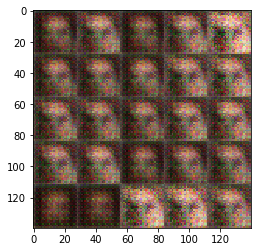

Epoch 0/2 ...  Discriminator Loss 1.0607826709747314 ...  Generator Loss 1.8402225971221924 
Epoch 0/2 ...  Discriminator Loss 1.045912265777588 ...  Generator Loss 2.047701358795166 
Epoch 0/2 ...  Discriminator Loss 1.06126070022583 ...  Generator Loss 1.7199652194976807 
Epoch 0/2 ...  Discriminator Loss 1.272410273551941 ...  Generator Loss 1.169283390045166 
Epoch 0/2 ...  Discriminator Loss 1.2600680589675903 ...  Generator Loss 1.1818689107894897 
Epoch 0/2 ...  Discriminator Loss 1.1267837285995483 ...  Generator Loss 1.27634596824646 
Epoch 0/2 ...  Discriminator Loss 1.0784732103347778 ...  Generator Loss 1.2364580631256104 
Epoch 0/2 ...  Discriminator Loss 1.29352605342865 ...  Generator Loss 1.3275116682052612 
Epoch 0/2 ...  Discriminator Loss 1.2295348644256592 ...  Generator Loss 1.621886134147644 
Epoch 0/2 ...  Discriminator Loss 1.0697212219238281 ...  Generator Loss 1.266061782836914 


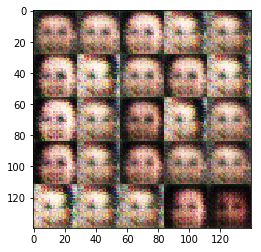

Epoch 0/2 ...  Discriminator Loss 1.035736083984375 ...  Generator Loss 1.267838954925537 
Epoch 0/2 ...  Discriminator Loss 1.0889298915863037 ...  Generator Loss 1.2992993593215942 
Epoch 0/2 ...  Discriminator Loss 1.0874576568603516 ...  Generator Loss 1.3554041385650635 
Epoch 0/2 ...  Discriminator Loss 1.1428048610687256 ...  Generator Loss 1.4475746154785156 
Epoch 0/2 ...  Discriminator Loss 0.9836233854293823 ...  Generator Loss 1.2755911350250244 
Epoch 0/2 ...  Discriminator Loss 1.1250241994857788 ...  Generator Loss 1.4274197816848755 
Epoch 0/2 ...  Discriminator Loss 1.050397276878357 ...  Generator Loss 1.6664941310882568 
Epoch 0/2 ...  Discriminator Loss 1.2161924839019775 ...  Generator Loss 1.8734312057495117 
Epoch 0/2 ...  Discriminator Loss 1.0974481105804443 ...  Generator Loss 1.3217628002166748 
Epoch 0/2 ...  Discriminator Loss 0.9755672216415405 ...  Generator Loss 1.1969809532165527 


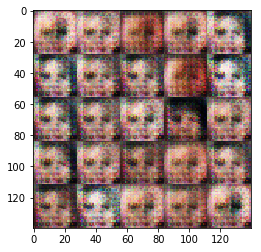

Epoch 0/2 ...  Discriminator Loss 0.89345383644104 ...  Generator Loss 1.493319034576416 
Epoch 0/2 ...  Discriminator Loss 1.0173344612121582 ...  Generator Loss 1.430952787399292 
Epoch 0/2 ...  Discriminator Loss 1.073799967765808 ...  Generator Loss 1.0986716747283936 
Epoch 0/2 ...  Discriminator Loss 1.149409532546997 ...  Generator Loss 0.9493781328201294 
Epoch 0/2 ...  Discriminator Loss 1.1926989555358887 ...  Generator Loss 1.3762768507003784 
Epoch 0/2 ...  Discriminator Loss 1.1097428798675537 ...  Generator Loss 1.454939365386963 
Epoch 0/2 ...  Discriminator Loss 1.1955500841140747 ...  Generator Loss 1.1927191019058228 
Epoch 0/2 ...  Discriminator Loss 1.148546814918518 ...  Generator Loss 1.1421462297439575 
Epoch 0/2 ...  Discriminator Loss 1.2749577760696411 ...  Generator Loss 1.3441963195800781 
Epoch 0/2 ...  Discriminator Loss 1.165826439857483 ...  Generator Loss 1.4343032836914062 


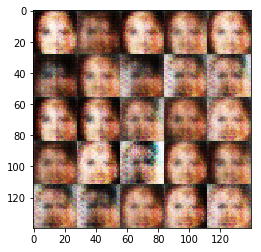

Epoch 0/2 ...  Discriminator Loss 1.141558289527893 ...  Generator Loss 1.2057137489318848 
Epoch 0/2 ...  Discriminator Loss 1.2836620807647705 ...  Generator Loss 1.3725383281707764 
Epoch 0/2 ...  Discriminator Loss 1.237067461013794 ...  Generator Loss 1.24589204788208 
Epoch 0/2 ...  Discriminator Loss 1.2366594076156616 ...  Generator Loss 1.1421819925308228 
Epoch 0/2 ...  Discriminator Loss 1.2239294052124023 ...  Generator Loss 1.3615778684616089 
Epoch 0/2 ...  Discriminator Loss 1.239525556564331 ...  Generator Loss 1.427192211151123 
Epoch 0/2 ...  Discriminator Loss 1.0769567489624023 ...  Generator Loss 1.3551876544952393 
Epoch 0/2 ...  Discriminator Loss 0.9866756796836853 ...  Generator Loss 1.4432276487350464 
Epoch 0/2 ...  Discriminator Loss 1.022568702697754 ...  Generator Loss 1.4916512966156006 
Epoch 0/2 ...  Discriminator Loss 1.1529440879821777 ...  Generator Loss 1.2543734312057495 


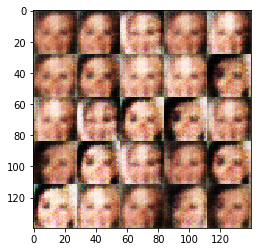

Epoch 0/2 ...  Discriminator Loss 1.0454192161560059 ...  Generator Loss 1.4334266185760498 
Epoch 0/2 ...  Discriminator Loss 1.1927809715270996 ...  Generator Loss 1.1664531230926514 
Epoch 0/2 ...  Discriminator Loss 1.1564972400665283 ...  Generator Loss 1.0535790920257568 
Epoch 0/2 ...  Discriminator Loss 1.2208385467529297 ...  Generator Loss 1.0930137634277344 
Epoch 0/2 ...  Discriminator Loss 1.2079172134399414 ...  Generator Loss 1.137317419052124 
Epoch 0/2 ...  Discriminator Loss 1.244720220565796 ...  Generator Loss 0.8848400115966797 
Epoch 0/2 ...  Discriminator Loss 1.0314334630966187 ...  Generator Loss 1.5668432712554932 
Epoch 0/2 ...  Discriminator Loss 1.221880555152893 ...  Generator Loss 1.3354947566986084 
Epoch 0/2 ...  Discriminator Loss 1.191627860069275 ...  Generator Loss 1.11417818069458 
Epoch 0/2 ...  Discriminator Loss 1.2109534740447998 ...  Generator Loss 0.8613294363021851 


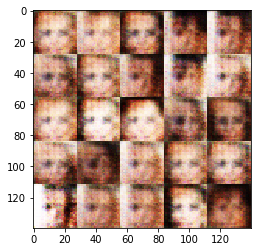

Epoch 0/2 ...  Discriminator Loss 1.1470019817352295 ...  Generator Loss 1.2856144905090332 
Epoch 0/2 ...  Discriminator Loss 1.2673332691192627 ...  Generator Loss 1.2389198541641235 
Epoch 0/2 ...  Discriminator Loss 1.3086810111999512 ...  Generator Loss 0.7135957479476929 
Epoch 0/2 ...  Discriminator Loss 1.056378722190857 ...  Generator Loss 1.4068622589111328 
Epoch 0/2 ...  Discriminator Loss 1.2178881168365479 ...  Generator Loss 1.2127532958984375 
Epoch 0/2 ...  Discriminator Loss 1.1186257600784302 ...  Generator Loss 1.1310701370239258 
Epoch 0/2 ...  Discriminator Loss 1.127325415611267 ...  Generator Loss 1.297417402267456 
Epoch 0/2 ...  Discriminator Loss 1.3035023212432861 ...  Generator Loss 1.1005980968475342 
Epoch 0/2 ...  Discriminator Loss 1.1180458068847656 ...  Generator Loss 1.5337989330291748 
Epoch 0/2 ...  Discriminator Loss 1.1806883811950684 ...  Generator Loss 1.1727943420410156 


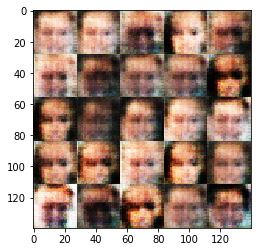

Epoch 0/2 ...  Discriminator Loss 1.1255836486816406 ...  Generator Loss 1.0618535280227661 
Epoch 0/2 ...  Discriminator Loss 1.2012044191360474 ...  Generator Loss 1.176236867904663 
Epoch 0/2 ...  Discriminator Loss 1.1467814445495605 ...  Generator Loss 1.0659253597259521 
Epoch 0/2 ...  Discriminator Loss 1.1075541973114014 ...  Generator Loss 1.342352032661438 
Epoch 0/2 ...  Discriminator Loss 1.2563188076019287 ...  Generator Loss 0.9502131938934326 
Epoch 0/2 ...  Discriminator Loss 1.282228708267212 ...  Generator Loss 0.8103320598602295 
Epoch 0/2 ...  Discriminator Loss 1.2245290279388428 ...  Generator Loss 1.147729516029358 
Epoch 0/2 ...  Discriminator Loss 1.2350916862487793 ...  Generator Loss 0.9982785582542419 
Epoch 0/2 ...  Discriminator Loss 1.2777347564697266 ...  Generator Loss 0.7873303890228271 
Epoch 0/2 ...  Discriminator Loss 1.1954532861709595 ...  Generator Loss 1.190897822380066 


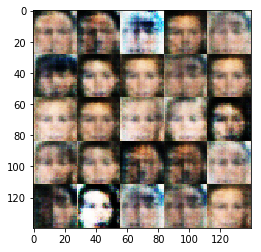

Epoch 0/2 ...  Discriminator Loss 1.0249382257461548 ...  Generator Loss 1.2350008487701416 
Epoch 0/2 ...  Discriminator Loss 1.0568115711212158 ...  Generator Loss 1.1033774614334106 
Epoch 0/2 ...  Discriminator Loss 1.1111993789672852 ...  Generator Loss 0.8274129629135132 
Epoch 0/2 ...  Discriminator Loss 1.1024647951126099 ...  Generator Loss 1.6696604490280151 
Epoch 0/2 ...  Discriminator Loss 1.2555376291275024 ...  Generator Loss 1.4044946432113647 
Epoch 0/2 ...  Discriminator Loss 1.1885405778884888 ...  Generator Loss 1.0082005262374878 
Epoch 0/2 ...  Discriminator Loss 1.1784412860870361 ...  Generator Loss 0.7214897274971008 
Epoch 0/2 ...  Discriminator Loss 1.0720765590667725 ...  Generator Loss 1.402853012084961 
Epoch 0/2 ...  Discriminator Loss 1.1197658777236938 ...  Generator Loss 1.3475090265274048 
Epoch 0/2 ...  Discriminator Loss 1.0900440216064453 ...  Generator Loss 1.2003507614135742 


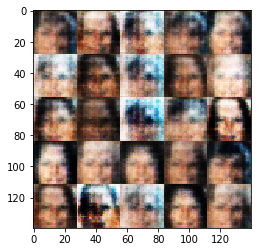

Epoch 0/2 ...  Discriminator Loss 1.172892689704895 ...  Generator Loss 1.4336323738098145 
Epoch 0/2 ...  Discriminator Loss 1.1329522132873535 ...  Generator Loss 1.4321181774139404 
Epoch 0/2 ...  Discriminator Loss 1.0182265043258667 ...  Generator Loss 1.4542434215545654 
Epoch 0/2 ...  Discriminator Loss 1.2021098136901855 ...  Generator Loss 1.6950128078460693 
Epoch 0/2 ...  Discriminator Loss 0.9325384497642517 ...  Generator Loss 1.5868107080459595 
Epoch 0/2 ...  Discriminator Loss 1.091294765472412 ...  Generator Loss 1.3033607006072998 
Epoch 0/2 ...  Discriminator Loss 1.023239016532898 ...  Generator Loss 1.0757343769073486 
Epoch 0/2 ...  Discriminator Loss 1.1629552841186523 ...  Generator Loss 1.431485652923584 
Epoch 0/2 ...  Discriminator Loss 1.1500444412231445 ...  Generator Loss 1.0121158361434937 
Epoch 0/2 ...  Discriminator Loss 1.1297388076782227 ...  Generator Loss 1.3369295597076416 


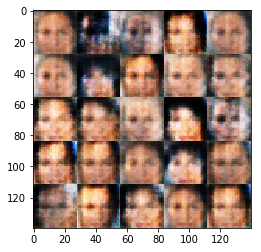

Epoch 0/2 ...  Discriminator Loss 1.1065001487731934 ...  Generator Loss 1.1953072547912598 
Epoch 0/2 ...  Discriminator Loss 1.2228167057037354 ...  Generator Loss 1.3226583003997803 
Epoch 0/2 ...  Discriminator Loss 1.1507916450500488 ...  Generator Loss 1.0204260349273682 
Epoch 0/2 ...  Discriminator Loss 1.0867539644241333 ...  Generator Loss 1.2728793621063232 
Epoch 0/2 ...  Discriminator Loss 1.1689352989196777 ...  Generator Loss 1.1289349794387817 
Epoch 0/2 ...  Discriminator Loss 1.176386833190918 ...  Generator Loss 0.9890178442001343 
Epoch 0/2 ...  Discriminator Loss 1.3188717365264893 ...  Generator Loss 1.6461397409439087 
Epoch 0/2 ...  Discriminator Loss 1.2377197742462158 ...  Generator Loss 1.1239204406738281 
Epoch 0/2 ...  Discriminator Loss 1.098541021347046 ...  Generator Loss 1.2033463716506958 
Epoch 0/2 ...  Discriminator Loss 1.3911867141723633 ...  Generator Loss 1.5254592895507812 


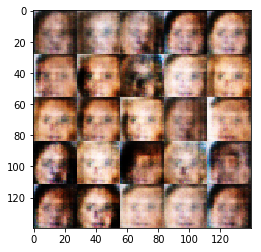

Epoch 0/2 ...  Discriminator Loss 1.1049373149871826 ...  Generator Loss 1.1101727485656738 
Epoch 0/2 ...  Discriminator Loss 1.3038220405578613 ...  Generator Loss 1.6921038627624512 
Epoch 0/2 ...  Discriminator Loss 1.1211079359054565 ...  Generator Loss 1.1756988763809204 
Epoch 0/2 ...  Discriminator Loss 1.1287775039672852 ...  Generator Loss 1.4669930934906006 
Epoch 0/2 ...  Discriminator Loss 1.0838637351989746 ...  Generator Loss 1.092040777206421 
Epoch 0/2 ...  Discriminator Loss 1.102198600769043 ...  Generator Loss 1.314902901649475 
Epoch 0/2 ...  Discriminator Loss 1.1215221881866455 ...  Generator Loss 1.0390150547027588 
Epoch 0/2 ...  Discriminator Loss 1.0677433013916016 ...  Generator Loss 1.0968588590621948 
Epoch 0/2 ...  Discriminator Loss 1.3242262601852417 ...  Generator Loss 0.5604346990585327 
Epoch 0/2 ...  Discriminator Loss 1.1841552257537842 ...  Generator Loss 1.4387810230255127 


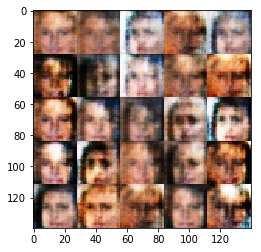

Epoch 0/2 ...  Discriminator Loss 1.1965018510818481 ...  Generator Loss 1.0581166744232178 
Epoch 0/2 ...  Discriminator Loss 1.2475169897079468 ...  Generator Loss 1.0772275924682617 
Epoch 0/2 ...  Discriminator Loss 1.2201052904129028 ...  Generator Loss 0.842750608921051 
Epoch 0/2 ...  Discriminator Loss 1.188017725944519 ...  Generator Loss 1.1329236030578613 
Epoch 0/2 ...  Discriminator Loss 1.1450166702270508 ...  Generator Loss 0.9596649408340454 
Epoch 0/2 ...  Discriminator Loss 1.235569715499878 ...  Generator Loss 1.4315440654754639 
Epoch 0/2 ...  Discriminator Loss 1.207021951675415 ...  Generator Loss 0.8134878873825073 
Epoch 0/2 ...  Discriminator Loss 1.1961243152618408 ...  Generator Loss 1.1598905324935913 
Epoch 0/2 ...  Discriminator Loss 1.1964010000228882 ...  Generator Loss 0.9318798184394836 
Epoch 0/2 ...  Discriminator Loss 1.189906358718872 ...  Generator Loss 1.0401840209960938 


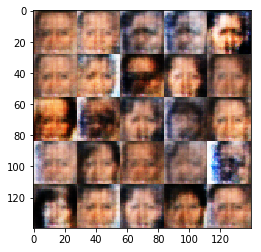

Epoch 0/2 ...  Discriminator Loss 1.1249330043792725 ...  Generator Loss 1.244262456893921 
Epoch 0/2 ...  Discriminator Loss 1.134416103363037 ...  Generator Loss 1.1068785190582275 
Epoch 0/2 ...  Discriminator Loss 1.1901754140853882 ...  Generator Loss 1.3015735149383545 
Epoch 0/2 ...  Discriminator Loss 1.1898127794265747 ...  Generator Loss 1.3247642517089844 
Epoch 0/2 ...  Discriminator Loss 1.3782809972763062 ...  Generator Loss 1.882215142250061 
Epoch 0/2 ...  Discriminator Loss 1.3499269485473633 ...  Generator Loss 1.526309609413147 
Epoch 0/2 ...  Discriminator Loss 1.1287543773651123 ...  Generator Loss 1.0266811847686768 
Epoch 0/2 ...  Discriminator Loss 1.1286356449127197 ...  Generator Loss 1.1981905698776245 
Epoch 0/2 ...  Discriminator Loss 1.1781820058822632 ...  Generator Loss 1.0010039806365967 
Epoch 0/2 ...  Discriminator Loss 1.0881332159042358 ...  Generator Loss 1.2543139457702637 


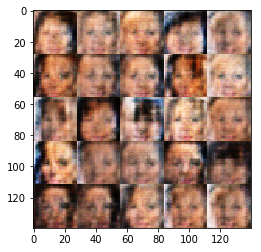

Epoch 0/2 ...  Discriminator Loss 1.140989065170288 ...  Generator Loss 1.3941161632537842 
Epoch 0/2 ...  Discriminator Loss 1.2162474393844604 ...  Generator Loss 0.8353798389434814 
Epoch 0/2 ...  Discriminator Loss 1.0036087036132812 ...  Generator Loss 1.6459535360336304 
Epoch 0/2 ...  Discriminator Loss 1.1800817251205444 ...  Generator Loss 1.0656769275665283 
Epoch 0/2 ...  Discriminator Loss 1.1317757368087769 ...  Generator Loss 1.0528355836868286 
Epoch 0/2 ...  Discriminator Loss 1.1201179027557373 ...  Generator Loss 0.8850225210189819 
Epoch 0/2 ...  Discriminator Loss 1.1855378150939941 ...  Generator Loss 1.0119891166687012 
Epoch 0/2 ...  Discriminator Loss 1.111149787902832 ...  Generator Loss 1.493904948234558 
Epoch 0/2 ...  Discriminator Loss 1.1532658338546753 ...  Generator Loss 1.0003371238708496 
Epoch 0/2 ...  Discriminator Loss 1.1779694557189941 ...  Generator Loss 1.0936660766601562 


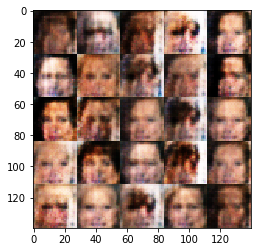

Epoch 0/2 ...  Discriminator Loss 1.1832963228225708 ...  Generator Loss 1.0493059158325195 
Epoch 0/2 ...  Discriminator Loss 1.1475393772125244 ...  Generator Loss 1.0441770553588867 
Epoch 0/2 ...  Discriminator Loss 1.059565782546997 ...  Generator Loss 1.2104344367980957 
Epoch 0/2 ...  Discriminator Loss 1.2330601215362549 ...  Generator Loss 1.1638160943984985 
Epoch 0/2 ...  Discriminator Loss 1.1173518896102905 ...  Generator Loss 1.252305269241333 
Epoch 0/2 ...  Discriminator Loss 1.2378971576690674 ...  Generator Loss 1.1899510622024536 
Epoch 0/2 ...  Discriminator Loss 1.1217457056045532 ...  Generator Loss 1.0133110284805298 
Epoch 0/2 ...  Discriminator Loss 1.2446441650390625 ...  Generator Loss 1.317142128944397 
Epoch 0/2 ...  Discriminator Loss 1.2497435808181763 ...  Generator Loss 1.0137184858322144 
Epoch 0/2 ...  Discriminator Loss 1.2340904474258423 ...  Generator Loss 1.2755987644195557 


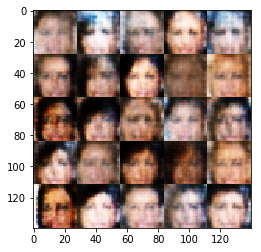

Epoch 0/2 ...  Discriminator Loss 1.1017552614212036 ...  Generator Loss 1.1855356693267822 
Epoch 0/2 ...  Discriminator Loss 1.282688021659851 ...  Generator Loss 0.9895740151405334 
Epoch 0/2 ...  Discriminator Loss 1.261977195739746 ...  Generator Loss 1.1681668758392334 
Epoch 0/2 ...  Discriminator Loss 1.1477675437927246 ...  Generator Loss 1.1446998119354248 
Epoch 0/2 ...  Discriminator Loss 1.074613094329834 ...  Generator Loss 1.331481695175171 
Epoch 0/2 ...  Discriminator Loss 1.1485785245895386 ...  Generator Loss 1.2707037925720215 
Epoch 0/2 ...  Discriminator Loss 1.1674325466156006 ...  Generator Loss 1.3585445880889893 
Epoch 0/2 ...  Discriminator Loss 1.2627400159835815 ...  Generator Loss 1.2525087594985962 
Epoch 0/2 ...  Discriminator Loss 1.075473666191101 ...  Generator Loss 1.4497183561325073 
Epoch 0/2 ...  Discriminator Loss 1.2055933475494385 ...  Generator Loss 1.0635247230529785 


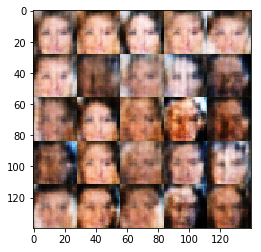

Epoch 0/2 ...  Discriminator Loss 1.1475107669830322 ...  Generator Loss 0.8975123167037964 
Epoch 0/2 ...  Discriminator Loss 1.1238350868225098 ...  Generator Loss 1.168332815170288 
Epoch 0/2 ...  Discriminator Loss 1.2258493900299072 ...  Generator Loss 1.4603970050811768 
Epoch 0/2 ...  Discriminator Loss 1.4343795776367188 ...  Generator Loss 1.90494966506958 
Epoch 0/2 ...  Discriminator Loss 1.2692875862121582 ...  Generator Loss 1.11350679397583 
Epoch 0/2 ...  Discriminator Loss 1.1606292724609375 ...  Generator Loss 0.9674391746520996 
Epoch 0/2 ...  Discriminator Loss 1.257546067237854 ...  Generator Loss 1.1045732498168945 
Epoch 0/2 ...  Discriminator Loss 1.1683980226516724 ...  Generator Loss 1.245903491973877 
Epoch 0/2 ...  Discriminator Loss 1.0787272453308105 ...  Generator Loss 1.225875735282898 
Epoch 0/2 ...  Discriminator Loss 1.2219020128250122 ...  Generator Loss 1.1147003173828125 


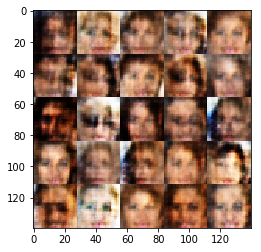

Epoch 0/2 ...  Discriminator Loss 1.098231554031372 ...  Generator Loss 1.0609822273254395 
Epoch 0/2 ...  Discriminator Loss 1.2446157932281494 ...  Generator Loss 1.325823426246643 
Epoch 0/2 ...  Discriminator Loss 1.0951499938964844 ...  Generator Loss 1.0598740577697754 
Epoch 0/2 ...  Discriminator Loss 1.2045129537582397 ...  Generator Loss 1.1177289485931396 
Epoch 0/2 ...  Discriminator Loss 1.569043517112732 ...  Generator Loss 1.8627777099609375 
Epoch 0/2 ...  Discriminator Loss 1.1223042011260986 ...  Generator Loss 1.4010642766952515 
Epoch 0/2 ...  Discriminator Loss 1.2129915952682495 ...  Generator Loss 1.4821242094039917 
Epoch 0/2 ...  Discriminator Loss 1.1013988256454468 ...  Generator Loss 0.8613379001617432 
Epoch 0/2 ...  Discriminator Loss 0.9553487300872803 ...  Generator Loss 1.1647100448608398 
Epoch 0/2 ...  Discriminator Loss 1.29745614528656 ...  Generator Loss 0.6376453042030334 


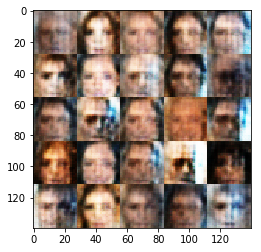

Epoch 0/2 ...  Discriminator Loss 1.0715789794921875 ...  Generator Loss 1.3532776832580566 
Epoch 0/2 ...  Discriminator Loss 1.144012212753296 ...  Generator Loss 1.1345696449279785 
Epoch 0/2 ...  Discriminator Loss 1.1217759847640991 ...  Generator Loss 1.1629383563995361 
Epoch 0/2 ...  Discriminator Loss 1.2501612901687622 ...  Generator Loss 1.703636646270752 
Epoch 0/2 ...  Discriminator Loss 1.0078842639923096 ...  Generator Loss 1.1135544776916504 
Epoch 0/2 ...  Discriminator Loss 1.213918924331665 ...  Generator Loss 1.1831588745117188 
Epoch 0/2 ...  Discriminator Loss 1.2059553861618042 ...  Generator Loss 1.086035966873169 
Epoch 0/2 ...  Discriminator Loss 1.1106011867523193 ...  Generator Loss 1.0953625440597534 
Epoch 0/2 ...  Discriminator Loss 1.2760614156723022 ...  Generator Loss 0.9088351726531982 
Epoch 0/2 ...  Discriminator Loss 1.1257307529449463 ...  Generator Loss 1.4948567152023315 


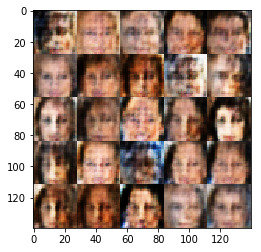

Epoch 0/2 ...  Discriminator Loss 1.1215678453445435 ...  Generator Loss 1.0483694076538086 
Epoch 0/2 ...  Discriminator Loss 1.154193639755249 ...  Generator Loss 0.8554667234420776 
Epoch 0/2 ...  Discriminator Loss 1.0607908964157104 ...  Generator Loss 1.1673328876495361 
Epoch 0/2 ...  Discriminator Loss 1.1645830869674683 ...  Generator Loss 1.4597055912017822 
Epoch 0/2 ...  Discriminator Loss 1.0585421323776245 ...  Generator Loss 1.150879979133606 
Epoch 0/2 ...  Discriminator Loss 1.1135056018829346 ...  Generator Loss 1.1015985012054443 
Epoch 0/2 ...  Discriminator Loss 1.0867514610290527 ...  Generator Loss 1.0251200199127197 
Epoch 0/2 ...  Discriminator Loss 1.1922246217727661 ...  Generator Loss 0.959088921546936 
Epoch 0/2 ...  Discriminator Loss 1.1292412281036377 ...  Generator Loss 0.873451828956604 
Epoch 0/2 ...  Discriminator Loss 1.14034903049469 ...  Generator Loss 0.8386721014976501 


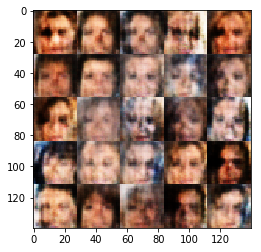

Epoch 0/2 ...  Discriminator Loss 1.0634236335754395 ...  Generator Loss 1.6095701456069946 
Epoch 0/2 ...  Discriminator Loss 1.152108907699585 ...  Generator Loss 1.1415547132492065 
Epoch 0/2 ...  Discriminator Loss 1.2638531923294067 ...  Generator Loss 0.7845736742019653 
Epoch 0/2 ...  Discriminator Loss 1.0354597568511963 ...  Generator Loss 1.2735071182250977 
Epoch 0/2 ...  Discriminator Loss 1.123956561088562 ...  Generator Loss 1.1163263320922852 
Epoch 0/2 ...  Discriminator Loss 1.0443768501281738 ...  Generator Loss 1.1461684703826904 
Epoch 0/2 ...  Discriminator Loss 1.2176098823547363 ...  Generator Loss 1.4294883012771606 
Epoch 0/2 ...  Discriminator Loss 1.0930135250091553 ...  Generator Loss 1.375258207321167 
Epoch 0/2 ...  Discriminator Loss 1.1357073783874512 ...  Generator Loss 0.9500345587730408 
Epoch 0/2 ...  Discriminator Loss 1.3413114547729492 ...  Generator Loss 0.9003221988677979 


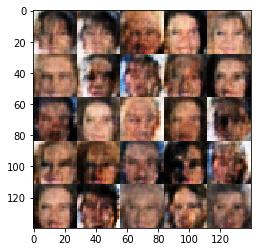

Epoch 0/2 ...  Discriminator Loss 1.0011897087097168 ...  Generator Loss 1.2479383945465088 
Epoch 0/2 ...  Discriminator Loss 1.188554286956787 ...  Generator Loss 1.0512291193008423 
Epoch 0/2 ...  Discriminator Loss 1.0837829113006592 ...  Generator Loss 1.1531902551651 
Epoch 0/2 ...  Discriminator Loss 1.1482053995132446 ...  Generator Loss 1.2491436004638672 
Epoch 0/2 ...  Discriminator Loss 1.1977347135543823 ...  Generator Loss 1.529430627822876 
Epoch 0/2 ...  Discriminator Loss 1.1162960529327393 ...  Generator Loss 0.9834348559379578 
Epoch 0/2 ...  Discriminator Loss 1.1337878704071045 ...  Generator Loss 1.196014642715454 
Epoch 0/2 ...  Discriminator Loss 1.3012380599975586 ...  Generator Loss 1.8487284183502197 
Epoch 0/2 ...  Discriminator Loss 1.15361487865448 ...  Generator Loss 1.15126633644104 
Epoch 0/2 ...  Discriminator Loss 1.1124701499938965 ...  Generator Loss 1.0493292808532715 


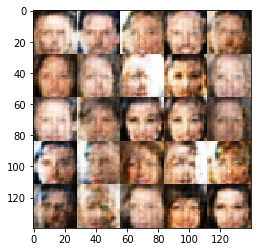

Epoch 0/2 ...  Discriminator Loss 1.1164661645889282 ...  Generator Loss 1.2645106315612793 
Epoch 0/2 ...  Discriminator Loss 1.2050940990447998 ...  Generator Loss 1.748521327972412 
Epoch 0/2 ...  Discriminator Loss 1.244528889656067 ...  Generator Loss 0.9467211961746216 
Epoch 0/2 ...  Discriminator Loss 1.1258631944656372 ...  Generator Loss 1.0207281112670898 
Epoch 0/2 ...  Discriminator Loss 1.1501659154891968 ...  Generator Loss 0.9703581929206848 
Epoch 0/2 ...  Discriminator Loss 1.0805883407592773 ...  Generator Loss 1.3023887872695923 
Epoch 0/2 ...  Discriminator Loss 1.1915528774261475 ...  Generator Loss 1.2232258319854736 
Epoch 0/2 ...  Discriminator Loss 1.152849793434143 ...  Generator Loss 1.0698728561401367 
Epoch 0/2 ...  Discriminator Loss 1.1230859756469727 ...  Generator Loss 1.0386440753936768 
Epoch 0/2 ...  Discriminator Loss 1.1068577766418457 ...  Generator Loss 1.1703280210494995 


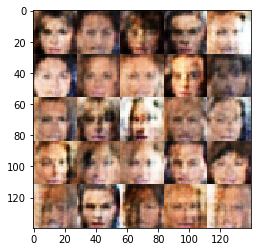

Epoch 0/2 ...  Discriminator Loss 1.1843175888061523 ...  Generator Loss 0.8060632944107056 
Epoch 0/2 ...  Discriminator Loss 1.1205112934112549 ...  Generator Loss 1.2153806686401367 
Epoch 0/2 ...  Discriminator Loss 1.1002552509307861 ...  Generator Loss 1.1339077949523926 
Epoch 0/2 ...  Discriminator Loss 1.1370606422424316 ...  Generator Loss 1.2723653316497803 
Epoch 0/2 ...  Discriminator Loss 1.0788078308105469 ...  Generator Loss 0.9695829749107361 
Epoch 0/2 ...  Discriminator Loss 1.2245337963104248 ...  Generator Loss 0.9915417432785034 
Epoch 0/2 ...  Discriminator Loss 1.1352546215057373 ...  Generator Loss 1.0656046867370605 
Epoch 0/2 ...  Discriminator Loss 1.1418029069900513 ...  Generator Loss 1.0111509561538696 
Epoch 0/2 ...  Discriminator Loss 1.1287944316864014 ...  Generator Loss 1.0256155729293823 
Epoch 0/2 ...  Discriminator Loss 1.075671911239624 ...  Generator Loss 1.2011210918426514 


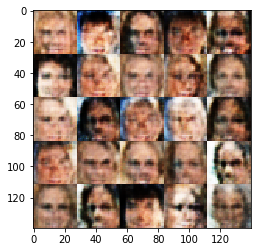

Epoch 0/2 ...  Discriminator Loss 1.185976505279541 ...  Generator Loss 1.6002600193023682 
Epoch 0/2 ...  Discriminator Loss 1.180304765701294 ...  Generator Loss 1.1513004302978516 
Epoch 0/2 ...  Discriminator Loss 1.0750480890274048 ...  Generator Loss 1.3816184997558594 
Epoch 0/2 ...  Discriminator Loss 1.1804476976394653 ...  Generator Loss 1.0089337825775146 
Epoch 0/2 ...  Discriminator Loss 1.3006064891815186 ...  Generator Loss 1.4861462116241455 
Epoch 0/2 ...  Discriminator Loss 1.1739696264266968 ...  Generator Loss 1.2228994369506836 
Epoch 0/2 ...  Discriminator Loss 0.9886573553085327 ...  Generator Loss 1.004117488861084 
Epoch 0/2 ...  Discriminator Loss 1.1158065795898438 ...  Generator Loss 1.003556728363037 
Epoch 0/2 ...  Discriminator Loss 1.0595333576202393 ...  Generator Loss 1.2153234481811523 
Epoch 0/2 ...  Discriminator Loss 1.1380701065063477 ...  Generator Loss 1.0534974336624146 


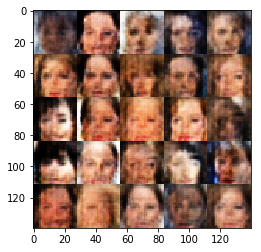

Epoch 0/2 ...  Discriminator Loss 1.1424932479858398 ...  Generator Loss 1.1102619171142578 
Epoch 0/2 ...  Discriminator Loss 1.081953763961792 ...  Generator Loss 1.2277741432189941 
Epoch 0/2 ...  Discriminator Loss 1.3142402172088623 ...  Generator Loss 1.4646084308624268 
Epoch 0/2 ...  Discriminator Loss 1.1033120155334473 ...  Generator Loss 0.9638336300849915 
Epoch 0/2 ...  Discriminator Loss 1.2641170024871826 ...  Generator Loss 1.408596158027649 
Epoch 0/2 ...  Discriminator Loss 1.0854544639587402 ...  Generator Loss 1.3166602849960327 
Epoch 0/2 ...  Discriminator Loss 1.5938799381256104 ...  Generator Loss 2.0489046573638916 
Epoch 0/2 ...  Discriminator Loss 1.280677080154419 ...  Generator Loss 1.1065794229507446 
Epoch 0/2 ...  Discriminator Loss 1.101813554763794 ...  Generator Loss 1.054235577583313 
Epoch 0/2 ...  Discriminator Loss 1.2561471462249756 ...  Generator Loss 1.2543010711669922 


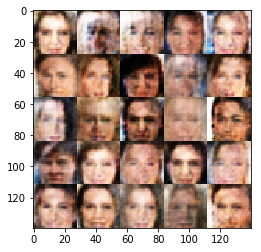

Epoch 0/2 ...  Discriminator Loss 1.1515377759933472 ...  Generator Loss 1.0315945148468018 
Epoch 0/2 ...  Discriminator Loss 1.1672536134719849 ...  Generator Loss 1.3520660400390625 
Epoch 0/2 ...  Discriminator Loss 1.2009676694869995 ...  Generator Loss 1.1752464771270752 
Epoch 0/2 ...  Discriminator Loss 1.1260082721710205 ...  Generator Loss 1.1048059463500977 
Epoch 0/2 ...  Discriminator Loss 1.14512038230896 ...  Generator Loss 1.0376720428466797 
Epoch 0/2 ...  Discriminator Loss 1.3919322490692139 ...  Generator Loss 1.752351999282837 
Epoch 0/2 ...  Discriminator Loss 1.1372191905975342 ...  Generator Loss 0.7909349799156189 
Epoch 0/2 ...  Discriminator Loss 1.221667766571045 ...  Generator Loss 1.6553317308425903 
Epoch 0/2 ...  Discriminator Loss 1.1556662321090698 ...  Generator Loss 1.1139473915100098 
Epoch 0/2 ...  Discriminator Loss 1.1493453979492188 ...  Generator Loss 0.8925787806510925 


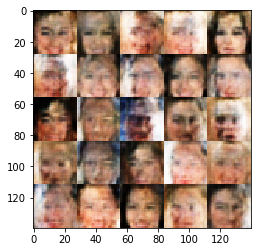

Epoch 0/2 ...  Discriminator Loss 1.1711852550506592 ...  Generator Loss 1.0475754737854004 
Epoch 0/2 ...  Discriminator Loss 1.1471877098083496 ...  Generator Loss 0.8784221410751343 
Epoch 0/2 ...  Discriminator Loss 1.0919065475463867 ...  Generator Loss 1.121150255203247 
Epoch 0/2 ...  Discriminator Loss 1.161043405532837 ...  Generator Loss 1.1111080646514893 
Epoch 0/2 ...  Discriminator Loss 1.160635232925415 ...  Generator Loss 1.0985252857208252 
Epoch 0/2 ...  Discriminator Loss 1.2299103736877441 ...  Generator Loss 0.8282020092010498 
Epoch 0/2 ...  Discriminator Loss 1.1431905031204224 ...  Generator Loss 1.189997673034668 
Epoch 0/2 ...  Discriminator Loss 1.1079347133636475 ...  Generator Loss 1.229856252670288 
Epoch 0/2 ...  Discriminator Loss 1.2035973072052002 ...  Generator Loss 1.3848270177841187 
Epoch 0/2 ...  Discriminator Loss 1.0909397602081299 ...  Generator Loss 1.3009291887283325 


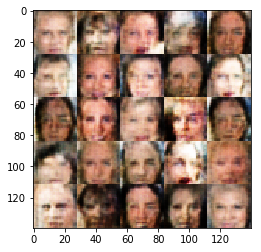

Epoch 0/2 ...  Discriminator Loss 1.0908056497573853 ...  Generator Loss 1.0643274784088135 
Epoch 0/2 ...  Discriminator Loss 1.2646286487579346 ...  Generator Loss 0.895505428314209 
Epoch 0/2 ...  Discriminator Loss 1.1044626235961914 ...  Generator Loss 1.0977898836135864 
Epoch 0/2 ...  Discriminator Loss 1.0791959762573242 ...  Generator Loss 1.0842335224151611 
Epoch 0/2 ...  Discriminator Loss 1.1567548513412476 ...  Generator Loss 1.1585044860839844 
Epoch 0/2 ...  Discriminator Loss 1.163745641708374 ...  Generator Loss 1.149742603302002 
Epoch 0/2 ...  Discriminator Loss 1.271874189376831 ...  Generator Loss 0.9368017911911011 
Epoch 0/2 ...  Discriminator Loss 1.1107139587402344 ...  Generator Loss 0.914913535118103 
Epoch 0/2 ...  Discriminator Loss 1.1020102500915527 ...  Generator Loss 0.9408352971076965 
Epoch 0/2 ...  Discriminator Loss 0.982550859451294 ...  Generator Loss 1.0760321617126465 


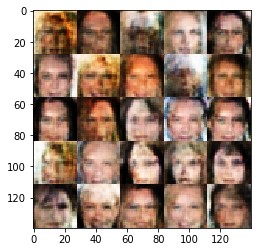

Epoch 0/2 ...  Discriminator Loss 1.1414568424224854 ...  Generator Loss 0.973004937171936 
Epoch 0/2 ...  Discriminator Loss 1.1297610998153687 ...  Generator Loss 0.8608920574188232 
Epoch 0/2 ...  Discriminator Loss 1.132279872894287 ...  Generator Loss 1.1550359725952148 
Epoch 0/2 ...  Discriminator Loss 1.1610808372497559 ...  Generator Loss 0.9504791498184204 
Epoch 0/2 ...  Discriminator Loss 1.3184409141540527 ...  Generator Loss 0.6330569386482239 
Epoch 0/2 ...  Discriminator Loss 1.1038000583648682 ...  Generator Loss 1.1837986707687378 
Epoch 0/2 ...  Discriminator Loss 1.1385856866836548 ...  Generator Loss 1.0704278945922852 
Epoch 0/2 ...  Discriminator Loss 1.2306702136993408 ...  Generator Loss 0.8702199459075928 
Epoch 0/2 ...  Discriminator Loss 1.1851177215576172 ...  Generator Loss 1.1776255369186401 
Epoch 0/2 ...  Discriminator Loss 1.0564720630645752 ...  Generator Loss 1.2133829593658447 


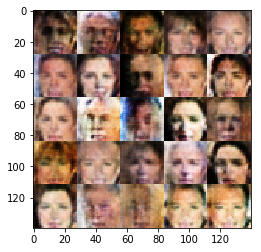

Epoch 0/2 ...  Discriminator Loss 1.2040126323699951 ...  Generator Loss 1.3354038000106812 
Epoch 0/2 ...  Discriminator Loss 1.1285176277160645 ...  Generator Loss 1.0732994079589844 
Epoch 0/2 ...  Discriminator Loss 1.1256107091903687 ...  Generator Loss 1.0050735473632812 
Epoch 0/2 ...  Discriminator Loss 1.1651687622070312 ...  Generator Loss 0.9271764755249023 
Epoch 0/2 ...  Discriminator Loss 1.111551284790039 ...  Generator Loss 1.2682019472122192 
Epoch 0/2 ...  Discriminator Loss 1.213110089302063 ...  Generator Loss 0.8373554348945618 
Epoch 1/2 ...  Discriminator Loss 1.0532490015029907 ...  Generator Loss 1.0522515773773193 
Epoch 1/2 ...  Discriminator Loss 1.1582499742507935 ...  Generator Loss 1.401721477508545 
Epoch 1/2 ...  Discriminator Loss 1.1671385765075684 ...  Generator Loss 1.3905258178710938 
Epoch 1/2 ...  Discriminator Loss 1.2045706510543823 ...  Generator Loss 1.4990758895874023 


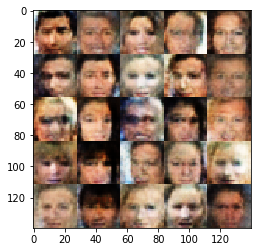

Epoch 1/2 ...  Discriminator Loss 1.1049745082855225 ...  Generator Loss 1.1024744510650635 
Epoch 1/2 ...  Discriminator Loss 1.1218057870864868 ...  Generator Loss 1.0713610649108887 
Epoch 1/2 ...  Discriminator Loss 1.2369074821472168 ...  Generator Loss 1.7628991603851318 
Epoch 1/2 ...  Discriminator Loss 1.292699933052063 ...  Generator Loss 1.6060740947723389 
Epoch 1/2 ...  Discriminator Loss 1.0895206928253174 ...  Generator Loss 0.963518500328064 
Epoch 1/2 ...  Discriminator Loss 1.1183472871780396 ...  Generator Loss 1.3075822591781616 
Epoch 1/2 ...  Discriminator Loss 1.0957534313201904 ...  Generator Loss 1.0896250009536743 
Epoch 1/2 ...  Discriminator Loss 1.197384238243103 ...  Generator Loss 0.9252510666847229 
Epoch 1/2 ...  Discriminator Loss 1.1930477619171143 ...  Generator Loss 0.7903329133987427 
Epoch 1/2 ...  Discriminator Loss 1.2226927280426025 ...  Generator Loss 1.114835262298584 


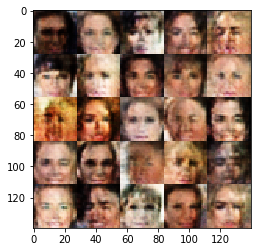

Epoch 1/2 ...  Discriminator Loss 1.10380220413208 ...  Generator Loss 0.9966716766357422 
Epoch 1/2 ...  Discriminator Loss 1.138786792755127 ...  Generator Loss 1.2999075651168823 
Epoch 1/2 ...  Discriminator Loss 1.110058307647705 ...  Generator Loss 1.2775728702545166 
Epoch 1/2 ...  Discriminator Loss 1.1258249282836914 ...  Generator Loss 1.0727686882019043 
Epoch 1/2 ...  Discriminator Loss 1.1285253763198853 ...  Generator Loss 1.2656629085540771 
Epoch 1/2 ...  Discriminator Loss 1.1882915496826172 ...  Generator Loss 1.6140458583831787 
Epoch 1/2 ...  Discriminator Loss 1.1530306339263916 ...  Generator Loss 1.0862699747085571 
Epoch 1/2 ...  Discriminator Loss 1.1767387390136719 ...  Generator Loss 0.8654406070709229 
Epoch 1/2 ...  Discriminator Loss 1.2096679210662842 ...  Generator Loss 0.8937584757804871 
Epoch 1/2 ...  Discriminator Loss 1.2356224060058594 ...  Generator Loss 0.8704802393913269 


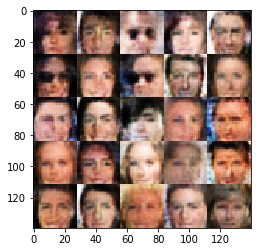

Epoch 1/2 ...  Discriminator Loss 1.163738489151001 ...  Generator Loss 1.0530893802642822 
Epoch 1/2 ...  Discriminator Loss 1.1684517860412598 ...  Generator Loss 0.8946080207824707 
Epoch 1/2 ...  Discriminator Loss 1.1507320404052734 ...  Generator Loss 1.118546724319458 
Epoch 1/2 ...  Discriminator Loss 1.1937878131866455 ...  Generator Loss 1.2590020895004272 
Epoch 1/2 ...  Discriminator Loss 1.1356571912765503 ...  Generator Loss 1.0480234622955322 
Epoch 1/2 ...  Discriminator Loss 1.0757371187210083 ...  Generator Loss 1.174859881401062 
Epoch 1/2 ...  Discriminator Loss 1.1015255451202393 ...  Generator Loss 1.1957097053527832 
Epoch 1/2 ...  Discriminator Loss 1.0964834690093994 ...  Generator Loss 1.18416166305542 
Epoch 1/2 ...  Discriminator Loss 1.1933228969573975 ...  Generator Loss 1.4539833068847656 
Epoch 1/2 ...  Discriminator Loss 1.0164563655853271 ...  Generator Loss 1.0813127756118774 


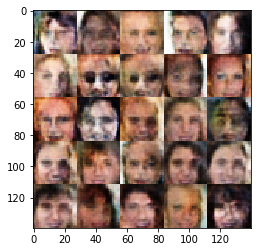

Epoch 1/2 ...  Discriminator Loss 1.0708577632904053 ...  Generator Loss 0.9569329023361206 
Epoch 1/2 ...  Discriminator Loss 1.0057461261749268 ...  Generator Loss 1.0257021188735962 
Epoch 1/2 ...  Discriminator Loss 1.1568161249160767 ...  Generator Loss 1.0194710493087769 
Epoch 1/2 ...  Discriminator Loss 1.073114037513733 ...  Generator Loss 1.441462516784668 
Epoch 1/2 ...  Discriminator Loss 1.0942811965942383 ...  Generator Loss 1.0244616270065308 
Epoch 1/2 ...  Discriminator Loss 1.2506687641143799 ...  Generator Loss 1.4199230670928955 
Epoch 1/2 ...  Discriminator Loss 1.1365855932235718 ...  Generator Loss 1.267277717590332 
Epoch 1/2 ...  Discriminator Loss 1.0353431701660156 ...  Generator Loss 1.011476993560791 
Epoch 1/2 ...  Discriminator Loss 1.0671381950378418 ...  Generator Loss 1.010498046875 
Epoch 1/2 ...  Discriminator Loss 0.9806060194969177 ...  Generator Loss 1.255129337310791 


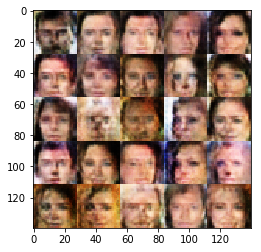

Epoch 1/2 ...  Discriminator Loss 1.0960144996643066 ...  Generator Loss 1.2676068544387817 
Epoch 1/2 ...  Discriminator Loss 1.1384875774383545 ...  Generator Loss 1.1068984270095825 
Epoch 1/2 ...  Discriminator Loss 1.1993070840835571 ...  Generator Loss 1.2016005516052246 
Epoch 1/2 ...  Discriminator Loss 1.1961488723754883 ...  Generator Loss 1.4834842681884766 
Epoch 1/2 ...  Discriminator Loss 1.1033135652542114 ...  Generator Loss 1.032804250717163 
Epoch 1/2 ...  Discriminator Loss 1.1417511701583862 ...  Generator Loss 1.1420140266418457 
Epoch 1/2 ...  Discriminator Loss 1.1066538095474243 ...  Generator Loss 1.3034694194793701 
Epoch 1/2 ...  Discriminator Loss 1.1355435848236084 ...  Generator Loss 1.206955909729004 
Epoch 1/2 ...  Discriminator Loss 1.185396432876587 ...  Generator Loss 1.146506667137146 
Epoch 1/2 ...  Discriminator Loss 1.1021554470062256 ...  Generator Loss 1.120639443397522 


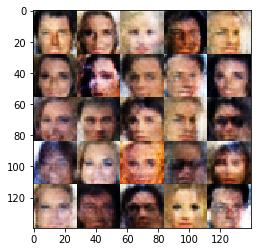

Epoch 1/2 ...  Discriminator Loss 1.089174747467041 ...  Generator Loss 1.0880589485168457 
Epoch 1/2 ...  Discriminator Loss 1.1087251901626587 ...  Generator Loss 1.179878830909729 
Epoch 1/2 ...  Discriminator Loss 1.1290215253829956 ...  Generator Loss 1.21966552734375 
Epoch 1/2 ...  Discriminator Loss 1.2383623123168945 ...  Generator Loss 1.0559865236282349 
Epoch 1/2 ...  Discriminator Loss 1.1471459865570068 ...  Generator Loss 1.0923728942871094 
Epoch 1/2 ...  Discriminator Loss 1.1936038732528687 ...  Generator Loss 1.4693434238433838 
Epoch 1/2 ...  Discriminator Loss 1.2712492942810059 ...  Generator Loss 1.713111162185669 
Epoch 1/2 ...  Discriminator Loss 1.150620937347412 ...  Generator Loss 1.4618914127349854 
Epoch 1/2 ...  Discriminator Loss 1.1654343605041504 ...  Generator Loss 0.9448686838150024 
Epoch 1/2 ...  Discriminator Loss 1.1415953636169434 ...  Generator Loss 1.241940975189209 


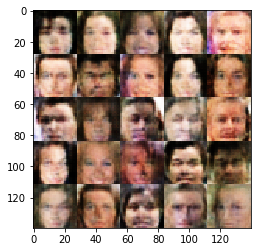

Epoch 1/2 ...  Discriminator Loss 1.0861644744873047 ...  Generator Loss 1.18453049659729 
Epoch 1/2 ...  Discriminator Loss 1.1522421836853027 ...  Generator Loss 1.2844487428665161 
Epoch 1/2 ...  Discriminator Loss 1.321636438369751 ...  Generator Loss 1.3183517456054688 
Epoch 1/2 ...  Discriminator Loss 1.1260318756103516 ...  Generator Loss 0.97918701171875 
Epoch 1/2 ...  Discriminator Loss 1.202580213546753 ...  Generator Loss 1.261857509613037 
Epoch 1/2 ...  Discriminator Loss 1.1419761180877686 ...  Generator Loss 0.8956202268600464 
Epoch 1/2 ...  Discriminator Loss 1.1005187034606934 ...  Generator Loss 0.9709824323654175 
Epoch 1/2 ...  Discriminator Loss 1.181132435798645 ...  Generator Loss 1.3072657585144043 
Epoch 1/2 ...  Discriminator Loss 1.09445059299469 ...  Generator Loss 1.1755108833312988 
Epoch 1/2 ...  Discriminator Loss 1.2248201370239258 ...  Generator Loss 0.8547732830047607 


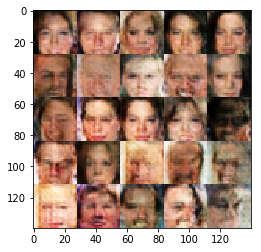

Epoch 1/2 ...  Discriminator Loss 1.162461280822754 ...  Generator Loss 1.4015389680862427 
Epoch 1/2 ...  Discriminator Loss 1.0628042221069336 ...  Generator Loss 1.0042104721069336 
Epoch 1/2 ...  Discriminator Loss 1.16069495677948 ...  Generator Loss 1.4937770366668701 
Epoch 1/2 ...  Discriminator Loss 1.1242883205413818 ...  Generator Loss 0.923882007598877 
Epoch 1/2 ...  Discriminator Loss 1.1695163249969482 ...  Generator Loss 1.3771882057189941 
Epoch 1/2 ...  Discriminator Loss 1.0710639953613281 ...  Generator Loss 1.1200544834136963 
Epoch 1/2 ...  Discriminator Loss 1.2268167734146118 ...  Generator Loss 1.6734578609466553 
Epoch 1/2 ...  Discriminator Loss 1.2239010334014893 ...  Generator Loss 1.0798993110656738 
Epoch 1/2 ...  Discriminator Loss 1.0949647426605225 ...  Generator Loss 1.093325138092041 
Epoch 1/2 ...  Discriminator Loss 1.0456185340881348 ...  Generator Loss 1.067746877670288 


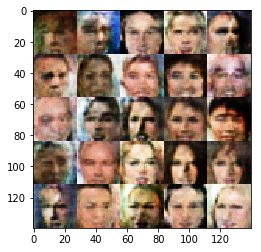

Epoch 1/2 ...  Discriminator Loss 1.195000410079956 ...  Generator Loss 1.2927777767181396 
Epoch 1/2 ...  Discriminator Loss 1.169168472290039 ...  Generator Loss 1.3276393413543701 
Epoch 1/2 ...  Discriminator Loss 1.1421140432357788 ...  Generator Loss 0.8847047686576843 
Epoch 1/2 ...  Discriminator Loss 1.12583589553833 ...  Generator Loss 1.2977490425109863 
Epoch 1/2 ...  Discriminator Loss 1.0407217741012573 ...  Generator Loss 1.0532715320587158 
Epoch 1/2 ...  Discriminator Loss 1.1267013549804688 ...  Generator Loss 0.9981734156608582 
Epoch 1/2 ...  Discriminator Loss 1.0196168422698975 ...  Generator Loss 1.4503521919250488 
Epoch 1/2 ...  Discriminator Loss 1.1543786525726318 ...  Generator Loss 1.3888599872589111 
Epoch 1/2 ...  Discriminator Loss 1.1673839092254639 ...  Generator Loss 1.6424198150634766 
Epoch 1/2 ...  Discriminator Loss 1.1320936679840088 ...  Generator Loss 0.9946112036705017 


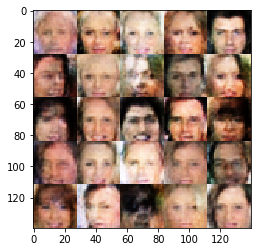

Epoch 1/2 ...  Discriminator Loss 1.141740322113037 ...  Generator Loss 1.3122589588165283 
Epoch 1/2 ...  Discriminator Loss 1.117084264755249 ...  Generator Loss 0.94687420129776 
Epoch 1/2 ...  Discriminator Loss 1.2809659242630005 ...  Generator Loss 0.6874853372573853 
Epoch 1/2 ...  Discriminator Loss 1.0847877264022827 ...  Generator Loss 0.8911027312278748 
Epoch 1/2 ...  Discriminator Loss 1.1570887565612793 ...  Generator Loss 0.7713025808334351 
Epoch 1/2 ...  Discriminator Loss 1.030588150024414 ...  Generator Loss 1.0752997398376465 
Epoch 1/2 ...  Discriminator Loss 1.042088270187378 ...  Generator Loss 1.2946512699127197 
Epoch 1/2 ...  Discriminator Loss 1.193037509918213 ...  Generator Loss 1.0371747016906738 
Epoch 1/2 ...  Discriminator Loss 1.1789463758468628 ...  Generator Loss 1.2503135204315186 
Epoch 1/2 ...  Discriminator Loss 1.1551477909088135 ...  Generator Loss 0.8885015249252319 


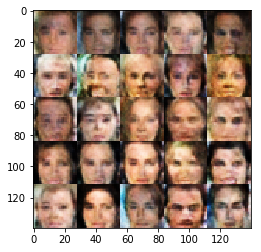

Epoch 1/2 ...  Discriminator Loss 1.1916685104370117 ...  Generator Loss 1.2223856449127197 
Epoch 1/2 ...  Discriminator Loss 1.1488776206970215 ...  Generator Loss 1.0045201778411865 
Epoch 1/2 ...  Discriminator Loss 1.1677675247192383 ...  Generator Loss 0.9782376289367676 
Epoch 1/2 ...  Discriminator Loss 1.081108808517456 ...  Generator Loss 1.0668984651565552 
Epoch 1/2 ...  Discriminator Loss 1.175656795501709 ...  Generator Loss 1.0697906017303467 
Epoch 1/2 ...  Discriminator Loss 1.0358637571334839 ...  Generator Loss 1.1532659530639648 
Epoch 1/2 ...  Discriminator Loss 1.162718653678894 ...  Generator Loss 1.3445913791656494 
Epoch 1/2 ...  Discriminator Loss 1.1202574968338013 ...  Generator Loss 1.0853009223937988 
Epoch 1/2 ...  Discriminator Loss 1.1634485721588135 ...  Generator Loss 1.255700945854187 
Epoch 1/2 ...  Discriminator Loss 1.0209619998931885 ...  Generator Loss 1.215803623199463 


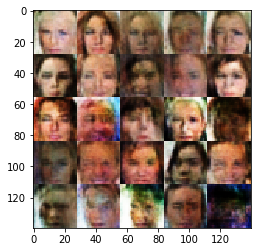

Epoch 1/2 ...  Discriminator Loss 1.1657835245132446 ...  Generator Loss 0.806075930595398 
Epoch 1/2 ...  Discriminator Loss 1.1632568836212158 ...  Generator Loss 1.0036777257919312 
Epoch 1/2 ...  Discriminator Loss 1.1560320854187012 ...  Generator Loss 0.8860753774642944 
Epoch 1/2 ...  Discriminator Loss 1.1018011569976807 ...  Generator Loss 1.1000062227249146 
Epoch 1/2 ...  Discriminator Loss 1.1149101257324219 ...  Generator Loss 0.8452777862548828 
Epoch 1/2 ...  Discriminator Loss 1.0965847969055176 ...  Generator Loss 0.9834907650947571 
Epoch 1/2 ...  Discriminator Loss 1.1390275955200195 ...  Generator Loss 1.4259233474731445 
Epoch 1/2 ...  Discriminator Loss 1.1136099100112915 ...  Generator Loss 1.060793161392212 
Epoch 1/2 ...  Discriminator Loss 1.180288314819336 ...  Generator Loss 1.2417395114898682 
Epoch 1/2 ...  Discriminator Loss 1.1187816858291626 ...  Generator Loss 1.448286533355713 


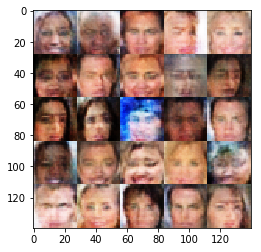

Epoch 1/2 ...  Discriminator Loss 1.097825050354004 ...  Generator Loss 1.127396583557129 
Epoch 1/2 ...  Discriminator Loss 1.118027687072754 ...  Generator Loss 1.13826584815979 
Epoch 1/2 ...  Discriminator Loss 1.1315879821777344 ...  Generator Loss 1.0677387714385986 
Epoch 1/2 ...  Discriminator Loss 1.121418833732605 ...  Generator Loss 1.0657168626785278 
Epoch 1/2 ...  Discriminator Loss 1.1214033365249634 ...  Generator Loss 0.9800142645835876 
Epoch 1/2 ...  Discriminator Loss 1.0413609743118286 ...  Generator Loss 1.1582757234573364 
Epoch 1/2 ...  Discriminator Loss 1.1322734355926514 ...  Generator Loss 1.4328577518463135 
Epoch 1/2 ...  Discriminator Loss 1.1070200204849243 ...  Generator Loss 1.1145038604736328 
Epoch 1/2 ...  Discriminator Loss 1.061533808708191 ...  Generator Loss 0.8591181039810181 
Epoch 1/2 ...  Discriminator Loss 1.153439998626709 ...  Generator Loss 0.9562165141105652 


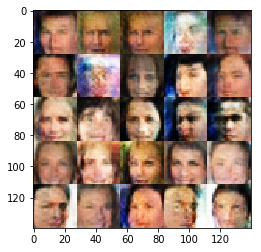

Epoch 1/2 ...  Discriminator Loss 1.1325981616973877 ...  Generator Loss 1.0424411296844482 
Epoch 1/2 ...  Discriminator Loss 1.1046514511108398 ...  Generator Loss 1.2987561225891113 
Epoch 1/2 ...  Discriminator Loss 1.142549753189087 ...  Generator Loss 1.012176752090454 
Epoch 1/2 ...  Discriminator Loss 1.2607959508895874 ...  Generator Loss 1.442756175994873 
Epoch 1/2 ...  Discriminator Loss 1.1504719257354736 ...  Generator Loss 1.315520167350769 
Epoch 1/2 ...  Discriminator Loss 1.15683114528656 ...  Generator Loss 1.3845090866088867 
Epoch 1/2 ...  Discriminator Loss 1.0811588764190674 ...  Generator Loss 1.1326138973236084 
Epoch 1/2 ...  Discriminator Loss 1.1216058731079102 ...  Generator Loss 1.052919626235962 
Epoch 1/2 ...  Discriminator Loss 1.1177165508270264 ...  Generator Loss 1.0022265911102295 
Epoch 1/2 ...  Discriminator Loss 1.107879638671875 ...  Generator Loss 1.3469624519348145 


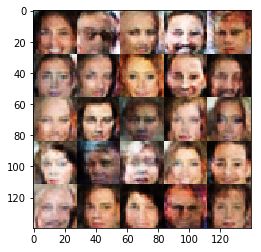

Epoch 1/2 ...  Discriminator Loss 1.2236442565917969 ...  Generator Loss 1.7120542526245117 
Epoch 1/2 ...  Discriminator Loss 1.2778074741363525 ...  Generator Loss 1.4698885679244995 
Epoch 1/2 ...  Discriminator Loss 1.1769211292266846 ...  Generator Loss 1.0122671127319336 
Epoch 1/2 ...  Discriminator Loss 1.0712411403656006 ...  Generator Loss 1.3180320262908936 
Epoch 1/2 ...  Discriminator Loss 1.1473815441131592 ...  Generator Loss 0.917411208152771 
Epoch 1/2 ...  Discriminator Loss 1.0550689697265625 ...  Generator Loss 1.1862947940826416 
Epoch 1/2 ...  Discriminator Loss 1.0897713899612427 ...  Generator Loss 1.1893227100372314 
Epoch 1/2 ...  Discriminator Loss 1.129373550415039 ...  Generator Loss 0.9596887826919556 
Epoch 1/2 ...  Discriminator Loss 1.1502652168273926 ...  Generator Loss 1.0966336727142334 
Epoch 1/2 ...  Discriminator Loss 1.1791572570800781 ...  Generator Loss 0.7713736295700073 


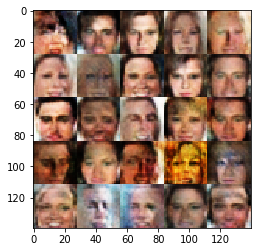

Epoch 1/2 ...  Discriminator Loss 1.0900967121124268 ...  Generator Loss 1.0816247463226318 
Epoch 1/2 ...  Discriminator Loss 1.0640567541122437 ...  Generator Loss 1.0328822135925293 
Epoch 1/2 ...  Discriminator Loss 1.1501673460006714 ...  Generator Loss 0.9434871673583984 
Epoch 1/2 ...  Discriminator Loss 1.0683178901672363 ...  Generator Loss 1.0436439514160156 
Epoch 1/2 ...  Discriminator Loss 1.1593140363693237 ...  Generator Loss 1.103947639465332 
Epoch 1/2 ...  Discriminator Loss 1.0143561363220215 ...  Generator Loss 1.0220481157302856 
Epoch 1/2 ...  Discriminator Loss 1.1317765712738037 ...  Generator Loss 0.9503533840179443 
Epoch 1/2 ...  Discriminator Loss 1.125284194946289 ...  Generator Loss 0.7878152132034302 
Epoch 1/2 ...  Discriminator Loss 1.11629319190979 ...  Generator Loss 1.289272427558899 
Epoch 1/2 ...  Discriminator Loss 1.1852340698242188 ...  Generator Loss 0.9187065958976746 


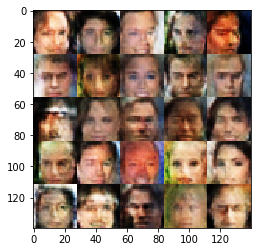

Epoch 1/2 ...  Discriminator Loss 1.082213044166565 ...  Generator Loss 1.1415400505065918 
Epoch 1/2 ...  Discriminator Loss 1.1722854375839233 ...  Generator Loss 1.3962732553482056 
Epoch 1/2 ...  Discriminator Loss 1.1947417259216309 ...  Generator Loss 0.8221887350082397 
Epoch 1/2 ...  Discriminator Loss 1.1196342706680298 ...  Generator Loss 1.2281197309494019 
Epoch 1/2 ...  Discriminator Loss 1.1347979307174683 ...  Generator Loss 0.944107711315155 
Epoch 1/2 ...  Discriminator Loss 1.1280481815338135 ...  Generator Loss 0.8360950946807861 
Epoch 1/2 ...  Discriminator Loss 1.1183565855026245 ...  Generator Loss 1.1655657291412354 
Epoch 1/2 ...  Discriminator Loss 1.1041814088821411 ...  Generator Loss 1.358963966369629 
Epoch 1/2 ...  Discriminator Loss 1.0578114986419678 ...  Generator Loss 1.2765045166015625 
Epoch 1/2 ...  Discriminator Loss 1.1360211372375488 ...  Generator Loss 1.027801752090454 


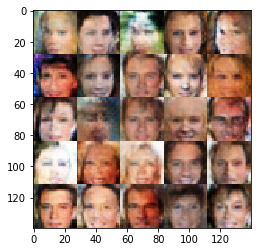

Epoch 1/2 ...  Discriminator Loss 1.1150823831558228 ...  Generator Loss 1.0491561889648438 
Epoch 1/2 ...  Discriminator Loss 1.0742348432540894 ...  Generator Loss 1.119206190109253 
Epoch 1/2 ...  Discriminator Loss 1.1571853160858154 ...  Generator Loss 0.8006068468093872 
Epoch 1/2 ...  Discriminator Loss 1.1858928203582764 ...  Generator Loss 0.7577946186065674 
Epoch 1/2 ...  Discriminator Loss 1.2425585985183716 ...  Generator Loss 0.9172017574310303 
Epoch 1/2 ...  Discriminator Loss 1.138014554977417 ...  Generator Loss 1.1529576778411865 
Epoch 1/2 ...  Discriminator Loss 1.1614675521850586 ...  Generator Loss 0.9021263122558594 
Epoch 1/2 ...  Discriminator Loss 1.137082815170288 ...  Generator Loss 1.212449312210083 
Epoch 1/2 ...  Discriminator Loss 1.114456295967102 ...  Generator Loss 1.0909805297851562 
Epoch 1/2 ...  Discriminator Loss 1.174612283706665 ...  Generator Loss 0.906859278678894 


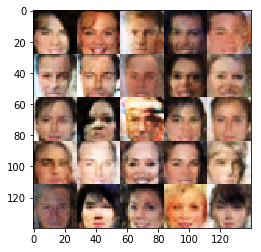

Epoch 1/2 ...  Discriminator Loss 1.1329500675201416 ...  Generator Loss 1.3004003763198853 
Epoch 1/2 ...  Discriminator Loss 1.1609468460083008 ...  Generator Loss 1.1854603290557861 
Epoch 1/2 ...  Discriminator Loss 1.134718418121338 ...  Generator Loss 1.0159268379211426 
Epoch 1/2 ...  Discriminator Loss 1.2229282855987549 ...  Generator Loss 0.7684539556503296 
Epoch 1/2 ...  Discriminator Loss 1.164315104484558 ...  Generator Loss 0.9381740093231201 
Epoch 1/2 ...  Discriminator Loss 1.1391241550445557 ...  Generator Loss 1.1864418983459473 
Epoch 1/2 ...  Discriminator Loss 1.1451961994171143 ...  Generator Loss 1.0806257724761963 
Epoch 1/2 ...  Discriminator Loss 1.2837496995925903 ...  Generator Loss 1.7568341493606567 
Epoch 1/2 ...  Discriminator Loss 1.1610209941864014 ...  Generator Loss 0.9692372679710388 
Epoch 1/2 ...  Discriminator Loss 1.213996410369873 ...  Generator Loss 1.1703720092773438 


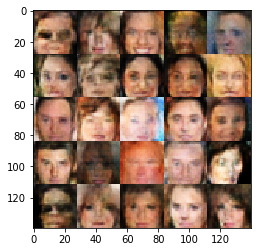

Epoch 1/2 ...  Discriminator Loss 1.175768256187439 ...  Generator Loss 0.8898806571960449 
Epoch 1/2 ...  Discriminator Loss 1.2074252367019653 ...  Generator Loss 0.8608421087265015 
Epoch 1/2 ...  Discriminator Loss 1.1440929174423218 ...  Generator Loss 0.9860520362854004 
Epoch 1/2 ...  Discriminator Loss 1.0923433303833008 ...  Generator Loss 1.1571242809295654 
Epoch 1/2 ...  Discriminator Loss 1.1632970571517944 ...  Generator Loss 0.948594331741333 
Epoch 1/2 ...  Discriminator Loss 1.1258853673934937 ...  Generator Loss 0.9163843393325806 
Epoch 1/2 ...  Discriminator Loss 1.1590639352798462 ...  Generator Loss 1.1323041915893555 
Epoch 1/2 ...  Discriminator Loss 1.027921438217163 ...  Generator Loss 1.2944834232330322 
Epoch 1/2 ...  Discriminator Loss 1.0976967811584473 ...  Generator Loss 0.9612837433815002 
Epoch 1/2 ...  Discriminator Loss 1.2292087078094482 ...  Generator Loss 1.1842067241668701 


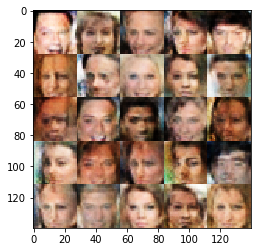

Epoch 1/2 ...  Discriminator Loss 1.215340495109558 ...  Generator Loss 0.7551651000976562 
Epoch 1/2 ...  Discriminator Loss 1.22066330909729 ...  Generator Loss 0.7537069916725159 
Epoch 1/2 ...  Discriminator Loss 1.1414328813552856 ...  Generator Loss 1.0557271242141724 
Epoch 1/2 ...  Discriminator Loss 1.13675856590271 ...  Generator Loss 0.8398346304893494 
Epoch 1/2 ...  Discriminator Loss 1.107627272605896 ...  Generator Loss 1.0449882745742798 
Epoch 1/2 ...  Discriminator Loss 1.0751235485076904 ...  Generator Loss 1.1152598857879639 
Epoch 1/2 ...  Discriminator Loss 1.22214937210083 ...  Generator Loss 0.7003011703491211 
Epoch 1/2 ...  Discriminator Loss 1.2704397439956665 ...  Generator Loss 1.5775487422943115 
Epoch 1/2 ...  Discriminator Loss 1.1616666316986084 ...  Generator Loss 0.9822865128517151 
Epoch 1/2 ...  Discriminator Loss 1.204021692276001 ...  Generator Loss 1.4228839874267578 


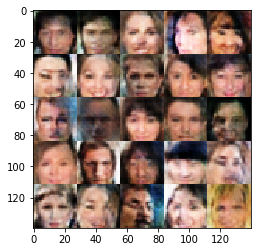

Epoch 1/2 ...  Discriminator Loss 1.1372308731079102 ...  Generator Loss 1.1933987140655518 
Epoch 1/2 ...  Discriminator Loss 1.1443312168121338 ...  Generator Loss 0.9266179203987122 
Epoch 1/2 ...  Discriminator Loss 1.1813547611236572 ...  Generator Loss 1.100146770477295 
Epoch 1/2 ...  Discriminator Loss 1.1185400485992432 ...  Generator Loss 1.317799687385559 
Epoch 1/2 ...  Discriminator Loss 1.185868263244629 ...  Generator Loss 0.8180798292160034 
Epoch 1/2 ...  Discriminator Loss 1.2054798603057861 ...  Generator Loss 0.9750555157661438 
Epoch 1/2 ...  Discriminator Loss 1.251432180404663 ...  Generator Loss 1.2776143550872803 
Epoch 1/2 ...  Discriminator Loss 1.1632959842681885 ...  Generator Loss 0.8674615621566772 
Epoch 1/2 ...  Discriminator Loss 1.080528736114502 ...  Generator Loss 1.1597652435302734 
Epoch 1/2 ...  Discriminator Loss 1.0995427370071411 ...  Generator Loss 1.186110258102417 


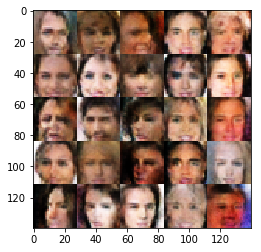

Epoch 1/2 ...  Discriminator Loss 1.197736144065857 ...  Generator Loss 1.0012710094451904 
Epoch 1/2 ...  Discriminator Loss 1.1931328773498535 ...  Generator Loss 1.0338280200958252 
Epoch 1/2 ...  Discriminator Loss 1.1639797687530518 ...  Generator Loss 0.9523977637290955 
Epoch 1/2 ...  Discriminator Loss 1.1470706462860107 ...  Generator Loss 1.1936877965927124 
Epoch 1/2 ...  Discriminator Loss 1.202768325805664 ...  Generator Loss 0.9718657732009888 
Epoch 1/2 ...  Discriminator Loss 1.1262032985687256 ...  Generator Loss 1.0740101337432861 
Epoch 1/2 ...  Discriminator Loss 1.0868866443634033 ...  Generator Loss 1.2448316812515259 
Epoch 1/2 ...  Discriminator Loss 1.2098424434661865 ...  Generator Loss 1.2040971517562866 
Epoch 1/2 ...  Discriminator Loss 1.190197229385376 ...  Generator Loss 0.9549044966697693 
Epoch 1/2 ...  Discriminator Loss 1.1546376943588257 ...  Generator Loss 1.081589698791504 


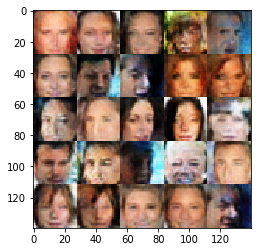

Epoch 1/2 ...  Discriminator Loss 1.1799572706222534 ...  Generator Loss 1.1428536176681519 
Epoch 1/2 ...  Discriminator Loss 1.1272828578948975 ...  Generator Loss 1.0362215042114258 
Epoch 1/2 ...  Discriminator Loss 1.2728028297424316 ...  Generator Loss 1.3563222885131836 
Epoch 1/2 ...  Discriminator Loss 1.1330097913742065 ...  Generator Loss 0.9774527549743652 
Epoch 1/2 ...  Discriminator Loss 1.1325794458389282 ...  Generator Loss 1.126884937286377 
Epoch 1/2 ...  Discriminator Loss 1.1368098258972168 ...  Generator Loss 1.0448029041290283 
Epoch 1/2 ...  Discriminator Loss 1.1786799430847168 ...  Generator Loss 1.17727530002594 
Epoch 1/2 ...  Discriminator Loss 1.184288740158081 ...  Generator Loss 1.1243923902511597 
Epoch 1/2 ...  Discriminator Loss 1.0977693796157837 ...  Generator Loss 0.9705985188484192 
Epoch 1/2 ...  Discriminator Loss 1.1585149765014648 ...  Generator Loss 1.1849353313446045 


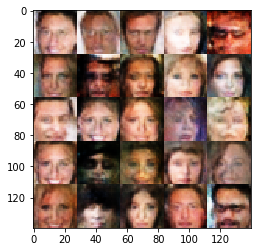

Epoch 1/2 ...  Discriminator Loss 1.184912919998169 ...  Generator Loss 0.9173241853713989 
Epoch 1/2 ...  Discriminator Loss 1.1019716262817383 ...  Generator Loss 1.2810555696487427 
Epoch 1/2 ...  Discriminator Loss 1.1725847721099854 ...  Generator Loss 1.0574661493301392 
Epoch 1/2 ...  Discriminator Loss 1.1283824443817139 ...  Generator Loss 1.1803622245788574 
Epoch 1/2 ...  Discriminator Loss 1.1562533378601074 ...  Generator Loss 1.2127209901809692 
Epoch 1/2 ...  Discriminator Loss 1.166252613067627 ...  Generator Loss 0.8094046115875244 
Epoch 1/2 ...  Discriminator Loss 1.1421051025390625 ...  Generator Loss 0.9533869028091431 
Epoch 1/2 ...  Discriminator Loss 1.1826350688934326 ...  Generator Loss 0.9849344491958618 
Epoch 1/2 ...  Discriminator Loss 1.1885682344436646 ...  Generator Loss 0.9102131128311157 
Epoch 1/2 ...  Discriminator Loss 1.1925832033157349 ...  Generator Loss 0.9789533615112305 


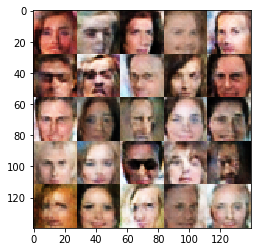

Epoch 1/2 ...  Discriminator Loss 1.1739555597305298 ...  Generator Loss 1.0687954425811768 
Epoch 1/2 ...  Discriminator Loss 1.1527246236801147 ...  Generator Loss 0.9952030181884766 
Epoch 1/2 ...  Discriminator Loss 1.2402892112731934 ...  Generator Loss 0.8178356885910034 
Epoch 1/2 ...  Discriminator Loss 1.1689419746398926 ...  Generator Loss 0.9417563676834106 
Epoch 1/2 ...  Discriminator Loss 1.1869257688522339 ...  Generator Loss 1.2406971454620361 
Epoch 1/2 ...  Discriminator Loss 1.1767454147338867 ...  Generator Loss 0.9964359402656555 
Epoch 1/2 ...  Discriminator Loss 1.172938346862793 ...  Generator Loss 0.9575208425521851 
Epoch 1/2 ...  Discriminator Loss 1.1799765825271606 ...  Generator Loss 1.1857290267944336 
Epoch 1/2 ...  Discriminator Loss 1.2167428731918335 ...  Generator Loss 1.2386757135391235 
Epoch 1/2 ...  Discriminator Loss 1.171739935874939 ...  Generator Loss 1.035290241241455 


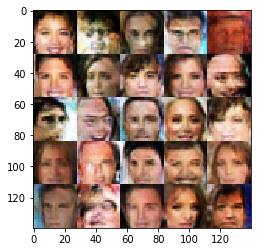

Epoch 1/2 ...  Discriminator Loss 1.166935682296753 ...  Generator Loss 1.314385175704956 
Epoch 1/2 ...  Discriminator Loss 1.1872990131378174 ...  Generator Loss 1.0719562768936157 
Epoch 1/2 ...  Discriminator Loss 1.1171655654907227 ...  Generator Loss 1.0118467807769775 
Epoch 1/2 ...  Discriminator Loss 1.1465879678726196 ...  Generator Loss 1.0591187477111816 
Epoch 1/2 ...  Discriminator Loss 1.1353533267974854 ...  Generator Loss 1.15061616897583 
Epoch 1/2 ...  Discriminator Loss 1.1172244548797607 ...  Generator Loss 1.376112699508667 
Epoch 1/2 ...  Discriminator Loss 1.1774260997772217 ...  Generator Loss 1.0333845615386963 
Epoch 1/2 ...  Discriminator Loss 1.1523678302764893 ...  Generator Loss 0.9665426015853882 
Epoch 1/2 ...  Discriminator Loss 1.180593729019165 ...  Generator Loss 1.0224673748016357 
Epoch 1/2 ...  Discriminator Loss 1.1384817361831665 ...  Generator Loss 1.0023061037063599 


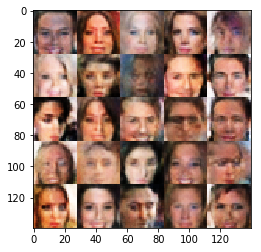

Epoch 1/2 ...  Discriminator Loss 1.177236795425415 ...  Generator Loss 0.8409392237663269 
Epoch 1/2 ...  Discriminator Loss 1.1817126274108887 ...  Generator Loss 1.324188232421875 
Epoch 1/2 ...  Discriminator Loss 1.1695799827575684 ...  Generator Loss 0.8957971334457397 
Epoch 1/2 ...  Discriminator Loss 1.1327381134033203 ...  Generator Loss 0.9064258933067322 
Epoch 1/2 ...  Discriminator Loss 1.159606695175171 ...  Generator Loss 0.8491279482841492 
Epoch 1/2 ...  Discriminator Loss 1.186867594718933 ...  Generator Loss 1.1727163791656494 
Epoch 1/2 ...  Discriminator Loss 1.1158944368362427 ...  Generator Loss 1.0775517225265503 
Epoch 1/2 ...  Discriminator Loss 1.187304139137268 ...  Generator Loss 0.9510180354118347 
Epoch 1/2 ...  Discriminator Loss 1.1572465896606445 ...  Generator Loss 1.1031701564788818 
Epoch 1/2 ...  Discriminator Loss 1.2875337600708008 ...  Generator Loss 1.4510397911071777 


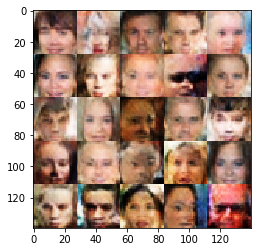

Epoch 1/2 ...  Discriminator Loss 1.1632001399993896 ...  Generator Loss 0.9299737215042114 
Epoch 1/2 ...  Discriminator Loss 1.142345905303955 ...  Generator Loss 1.2356866598129272 
Epoch 1/2 ...  Discriminator Loss 1.123659610748291 ...  Generator Loss 1.1639950275421143 
Epoch 1/2 ...  Discriminator Loss 1.145604133605957 ...  Generator Loss 0.9090875387191772 
Epoch 1/2 ...  Discriminator Loss 1.1735925674438477 ...  Generator Loss 0.9118001461029053 
Epoch 1/2 ...  Discriminator Loss 1.2735717296600342 ...  Generator Loss 1.4502997398376465 
Epoch 1/2 ...  Discriminator Loss 1.225846529006958 ...  Generator Loss 0.8523441553115845 
Epoch 1/2 ...  Discriminator Loss 1.2327147722244263 ...  Generator Loss 0.9329506158828735 
Epoch 1/2 ...  Discriminator Loss 1.1717190742492676 ...  Generator Loss 0.9552902579307556 
Epoch 1/2 ...  Discriminator Loss 1.2026557922363281 ...  Generator Loss 1.0256152153015137 


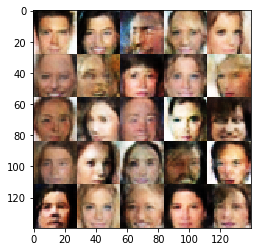

Epoch 1/2 ...  Discriminator Loss 1.1958261728286743 ...  Generator Loss 0.867477297782898 
Epoch 1/2 ...  Discriminator Loss 1.2005095481872559 ...  Generator Loss 0.9111700057983398 
Epoch 1/2 ...  Discriminator Loss 1.1196402311325073 ...  Generator Loss 1.0382311344146729 
Epoch 1/2 ...  Discriminator Loss 1.1098036766052246 ...  Generator Loss 1.2714155912399292 
Epoch 1/2 ...  Discriminator Loss 1.2456161975860596 ...  Generator Loss 1.1533567905426025 
Epoch 1/2 ...  Discriminator Loss 1.0786876678466797 ...  Generator Loss 1.1536645889282227 
Epoch 1/2 ...  Discriminator Loss 1.1410354375839233 ...  Generator Loss 1.0691423416137695 
Epoch 1/2 ...  Discriminator Loss 1.2003942728042603 ...  Generator Loss 1.0839576721191406 
Epoch 1/2 ...  Discriminator Loss 1.159102201461792 ...  Generator Loss 1.2066303491592407 
Epoch 1/2 ...  Discriminator Loss 1.2120994329452515 ...  Generator Loss 0.8247136473655701 


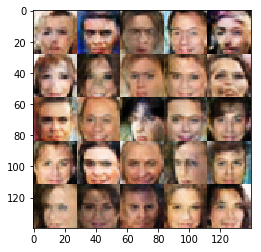

Epoch 1/2 ...  Discriminator Loss 1.1197969913482666 ...  Generator Loss 1.1808850765228271 
Epoch 1/2 ...  Discriminator Loss 1.1360740661621094 ...  Generator Loss 0.983834445476532 
Epoch 1/2 ...  Discriminator Loss 1.1706771850585938 ...  Generator Loss 0.8961679935455322 
Epoch 1/2 ...  Discriminator Loss 1.1858752965927124 ...  Generator Loss 1.0636351108551025 
Epoch 1/2 ...  Discriminator Loss 1.1956462860107422 ...  Generator Loss 1.1995086669921875 
Epoch 1/2 ...  Discriminator Loss 1.1963725090026855 ...  Generator Loss 1.2262802124023438 
Epoch 1/2 ...  Discriminator Loss 1.2098820209503174 ...  Generator Loss 0.9522241950035095 
Epoch 1/2 ...  Discriminator Loss 1.1289148330688477 ...  Generator Loss 1.0440573692321777 
Epoch 1/2 ...  Discriminator Loss 1.1640421152114868 ...  Generator Loss 0.9444364309310913 
Epoch 1/2 ...  Discriminator Loss 1.1914710998535156 ...  Generator Loss 0.9676191806793213 


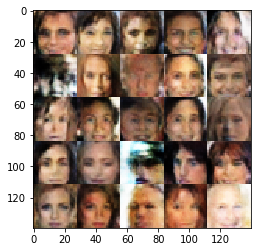

Epoch 1/2 ...  Discriminator Loss 1.1857249736785889 ...  Generator Loss 1.129257082939148 
Epoch 1/2 ...  Discriminator Loss 1.2089917659759521 ...  Generator Loss 0.9140325784683228 
Epoch 1/2 ...  Discriminator Loss 1.2588390111923218 ...  Generator Loss 0.8413617610931396 


In [13]:
batch_size = 64
z_dim = 200
learning_rate = .0005
beta1 = .3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.